## 1. Introduction
logiczny wykres tego co chesz storzyć, decyzja proces.



Imagine this: bustling factories, a symphony of activity as products roll off the assembly line. To keep things running like a well-oiled machine, these factories tap into a global network of suppliers, sometimes even doubling down on their sourcing strategies for extra resilience.

Now, let's zoom into our project: We're delving deep into the world of manufacturing, shining a spotlight on aluminum LED profiles. These sleek components are essential in modern lighting, but ensuring their quality is no walk in the park.

Our mission? To create a predictive model that can separate the wheat from the chaff when it comes to incoming goods. Simply put, we want to confidently label items as either 'OK' or 'NOK' (that's 'not OK' for the uninitiated).

But here's where it gets really interesting: beyond just sorting through shipments, our model could be a game-changer. Imagine quality assurance teams breathing easier, logistics experts streamlining processes, and R&D teams designing products with fewer bumps in the road.

So, while we're currently immersed in data and algorithms, the true magic lies in the potential impact of this project. And let's not forget the real-world expertise behind it all: I'm Grzegorz Kowalczyk, with 11 years in the manufacturing industry, including 5 as a quality manager. Oh, and by the way, our dataset, though rooted in reality, has been encoded for data protection.

# Quality Control prediction for incoming goods.

### **Grzegorz Kowalczyk**
#### 01/03/2024

* **1 Introduction**
* **2 Load and check data**
    * 2.1 Load data
    * 2.2 Data dictionary
    * 2.3 Data types, empty strings
    * 2.4 Null and missing values
    * 2.5 CatBoost prediction
    * 2.5 Data distribution
* **3 Data preprocessing**
    * 3.1 Data cleaning
* **4 Filling missing Values**
    * 4.1 Age
* **5 Outlier detection and removal**      
* **6 Feature analysis**
    * 6.1 Numerical values
      
        * pcs_pck - log transformation and MinMax: pcs_pck_scaler
        * pcs_length_mm - bins
        * overall_weight_kg - log transformation
        * quantity_pcs - bins
        * pack_weight_kg - log transformation and MinMax: pack_weight_scaler
        * delivered_pcs_pack - dropped
  
    * 6.2 Categorical values
      
        * name
        * shape_no
        * drawing_no
        * surface_finish
        * supplier
  
* **7 Modeling**
    * 7.1 Simple modeling
        * Cross validate models
        * Hyperparameter tuning for best models
        * Plot learning curves
        * Feature importance of the tree-based classifiers
    * 7.2 Ensemble modeling
        * Combining models
    * 7.3 Prediction
        * Predict low occurance classes


In [3]:
import pandas as pd
# pd.set_option('display.max_rows', None)
import numpy as np
import regex as re
from datetime import datetime, timedelta
from random import randint
import missingno
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from collections import Counter
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.2f}'.format
# !pip install openpyxl
# !pip install regex
# !pip install imbalanced-learn

## 2. Load and check data

So, here's the lowdown on our dataset: it's basically our Quality Control (QC) Excel file, filled to the brim with insights from real-life inspections. Think of it as a snapshot of six years' worth of shipments getting the once-over.

We're talking about a whopping 6448 entries in total, covering every inspection we've ever done. Now, not all columns are created equal – only three of them a beeing shown asre numericand by just looking at columns we know that it aint the truthon.

But let me tell you, this dataset isn't just a walk in the park. It's more like a rollercoaster ride through the ups and downs of human error. We've got everything from pesky NaNs (that's "Not a Numated) to weird symbols, sneaky white spaces, and even some data that's been shifted out of place.

So yeah,it of a mess, but hey, that's where the fun begins, right? Time to roll up our sleeves and dive into the chaos, because buried beneath all those errors lies the key to unlocking some serious isghts."

### 2.1 load data

In [4]:
df = pd.read_excel('../Github depo/QC_encoded_data.xlsx')

In [5]:
df.head()

,date,finish,delivered_pcs_pack,pack_weight_kg,OK_NOK,pcs_lenght_mm,quantity_pcs,overal_weight_kg,pcs_pck,name_e,drawing_no_e,shape_no_e,supplier_e
0,"13,01,2017",color2,NaN,NaN,NOK,NaN,NaN,NaN,40.00,Lepus,DR0,SH0,SU0
1,"13,01,2017",color2,NaN,NaN,NOK,NaN,NaN,NaN,40.00,Sargas,DR1,SH1,SU0
2,"13,01,2017",color2,NaN,NaN,NOK,NaN,NaN,NaN,40.00,Lepus,DR0,SH0,SU0
3,"13,01,2017",color2,NaN,NaN,NOK,NaN,NaN,NaN,40.00,Lepus,DR0,SH0,SU0
4,"19,01,2017",color2,NaN,NaN,NOK,NaN,NaN,NaN,40.00,Hercules2,DR2,SH2,SU1


In [6]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6448 entries, 0 to 6447
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                6403 non-null   object 
 1   finish              6448 non-null   object 
 2   delivered_pcs_pack  4807 non-null   object 
 3   pack_weight_kg      2411 non-null   object 
 4   OK_NOK              6448 non-null   object 
 5   pcs_lenght_mm       4514 non-null   float64
 6   quantity_pcs        4514 non-null   object 
 7   overal_weight_kg    4488 non-null   float64
 8   pcs_pck             6350 non-null   float64
 9   name_e              6448 non-null   object 
 10  drawing_no_e        6448 non-null   object 
 11  shape_no_e          6448 non-null   object 
 12  supplier_e          6448 non-null   object 
dtypes: float64(3), object(10)
memory usage: 3.4 MB


Lets rename and rearenge the columns

In [7]:
new_order = ['OK_NOK','date', 'name_e', 'shape_no_e', 'drawing_no_e', 'finish', 'supplier_e', 'pcs_pck','delivered_pcs_pack', 'pack_weight_kg', 
       'pcs_lenght_mm', 'quantity_pcs', 'overal_weight_kg']

In [8]:
df = df[new_order]

In [9]:
df = df.rename(columns={'overal_weight_kg': 'overall_weight_kg', 'pcs_pck': 'pcs_pack','name_e' : 'name', 'shape_no_e' : 'shape_no', 'drawing_no_e': 'drawing_no', 'supplier_e': 'supplier', 'finish': 'surface_finish'})

In [10]:
df.head()

,OK_NOK,date,name,shape_no,drawing_no,surface_finish,supplier,pcs_pack,delivered_pcs_pack,pack_weight_kg,pcs_lenght_mm,quantity_pcs,overall_weight_kg
0,NOK,"13,01,2017",Lepus,SH0,DR0,color2,SU0,40.00,NaN,NaN,NaN,NaN,NaN
1,NOK,"13,01,2017",Sargas,SH1,DR1,color2,SU0,40.00,NaN,NaN,NaN,NaN,NaN
2,NOK,"13,01,2017",Lepus,SH0,DR0,color2,SU0,40.00,NaN,NaN,NaN,NaN,NaN
3,NOK,"13,01,2017",Lepus,SH0,DR0,color2,SU0,40.00,NaN,NaN,NaN,NaN,NaN
4,NOK,"19,01,2017",Hercules2,SH2,DR2,color2,SU1,40.00,NaN,NaN,NaN,NaN,NaN


Describe function finds only 3 numeric features.

In [11]:
df.describe()

,pcs_pack,pcs_lenght_mm,overall_weight_kg
count,6350.00,4514.00,4488.00
mean,38.54,4078.38,438.28
std,22.97,227.00,226.47
min,2.00,1500.00,0.00
25%,20.00,4050.00,258.39
50%,40.00,4150.00,450.36
75%,40.00,4150.00,568.22
max,100.00,5100.00,1702.41


## 2.2 Data dictionary

* 0.   **OK_NOK**:
      This column contains a target label   
* 1.   **date**:
      Date of delivery
* 2.   **name**:
      This column consist of aluminum profile names
* 3.   **shape_no**:
      Number that defines shape of the aluminium profile.
      Shape itself dosn't describe the final product because many suppliers can deliver the same shape in many colours and at different lenghts
* 4.   **drawing_no**:
      Describes a shape and supplier but dosn't contain information about colours and different lenghts
* 5.   **surface_finish**:
      Information about the colour of the profile
* 6.   **supplier**:
      Name of the supplier
* 7.   **pcs_pack**:
      Number of aluminium profiles that should be delivered in one package
* 8.   **delivered_pcs_pack**:
      Number of aluminium profiles that ware delivered in one package
* 9.   **pack_weight_kg**:
      Weight of one package
* 10.  **pcs_lenght_mm**:
      Lenght of the aluminium profiles
* 11.  **quantity_pcs**:
      How many pcs where delivered 
* 12.  **overall_weight_kg**:
      The overal weight delivered profiles

### 2.3 Early CatBoost Algorithm Run

Before diving into extensive data preprocessing, we often kickstart our analysis by running a preliminary CatBoost algorithm. This approach serves multiple purposes:

1. **Baseline Performance Assessment**: By applying CatBoost to our raw dataset, we obtain initial performance metrics that serve as a baseline for comparison. These metrics, including accuracy, precision, recall, and F1 score, provide insights into the algorithm's performance on unprocessed data.

2. **Identification of Data Challenges**: Running CatBoost early allows us to identify potential challenges within the dataset. Any significant discrepancies or anomalies in the performance metrics may indicate underlying issues such as data imbalance, missing values, or feature engineering requirements.

3. **Hypothesis Generation**: The initial results from CatBoost can spark hypotheses regarding feature importance and model behavior. Observing which features CatBoost deems significant in its initial run can guide our subsequent data preprocessing efforts and feature selection strategies.

4. **Quick Iterative Feedback Loop**: Running CatBoost early facilitates a quick iterative feedback loop. We can swiftly experiment with different preprocessing techniques and feature engineering approaches, iteratively refining our model based on the initial insights gained.

In this preliminary run, we split the dataset into training and testing sets, with 80% for training and 20% for testing. We employ CatBoost with categorical features specified and evaluate its performance using various metrics. Ultimately, we aim to gain initial insights into the dataset's predictability and establish a foundation for further model refinement and optimization.


Transforming target labels into binary format for classification. Now, our project's focus revolves around a clear distinction: 'OK' as 1 and 'NOK' as 0.

In [12]:
df['OK_NOK'] = df['OK_NOK'].map({'OK': 1, 'NOK': 0})

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from catboost import CatBoostClassifier


df.delivered_pcs_pack = df.delivered_pcs_pack.astype(str)
df.pack_weight_kg = df.pack_weight_kg.astype(str)
y = df['OK_NOK']
X = df.drop(['OK_NOK', 'date'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


cat_features = ['name','shape_no','drawing_no', 'surface_finish', 'supplier', 'delivered_pcs_pack','pack_weight_kg']

catb = CatBoostClassifier(cat_features=cat_features,random_state=42)

# Traing the model
train = catb.fit(X_train, y_train)

#Predict
y_pred = catb.predict(X_test)

# Scoring metrics
test_accuracy = catb.score(X_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred,pos_label=1)
roc_auc = roc_auc_score(y_test, y_pred)

precision_negative = precision_score(y_test, y_pred, pos_label=0)
recall_negative = recall_score(y_test, y_pred, pos_label=0)
f1_negative = f1_score(y_test, y_pred, pos_label=0)

Learning rate set to 0.020757
0:	learn: 0.6768825	total: 168ms	remaining: 2m 47s
1:	learn: 0.6622030	total: 182ms	remaining: 1m 30s
2:	learn: 0.6476796	total: 197ms	remaining: 1m 5s
3:	learn: 0.6336795	total: 222ms	remaining: 55.2s
4:	learn: 0.6197437	total: 243ms	remaining: 48.3s
5:	learn: 0.6073387	total: 254ms	remaining: 42.1s
6:	learn: 0.5944796	total: 275ms	remaining: 39.1s
7:	learn: 0.5835351	total: 286ms	remaining: 35.5s
8:	learn: 0.5730949	total: 305ms	remaining: 33.6s
9:	learn: 0.5633107	total: 315ms	remaining: 31.2s
10:	learn: 0.5539551	total: 323ms	remaining: 29s
11:	learn: 0.5445399	total: 341ms	remaining: 28.1s
12:	learn: 0.5352593	total: 361ms	remaining: 27.4s
13:	learn: 0.5269703	total: 382ms	remaining: 26.9s
14:	learn: 0.5191278	total: 403ms	remaining: 26.4s
15:	learn: 0.5115242	total: 425ms	remaining: 26.1s
16:	learn: 0.5043164	total: 448ms	remaining: 25.9s
17:	learn: 0.4976978	total: 469ms	remaining: 25.6s
18:	learn: 0.4903972	total: 491ms	remaining: 25.4s
19:	learn: 

In [14]:
df['OK_NOK'].value_counts()

OK_NOK
1    5224
0    1224
Name: count, dtype: int64

In [15]:
print(f' acc: {test_accuracy:.2f}, precision: {precision:.2f}, recall: {recall:.2f}, f1: {f1:.2f}, precision_negative: {precision_negative:.2f}, recall_negative: {recall_negative:.2f}, f1_negative: {f1_negative:.2f}, roc_auc: {roc_auc:.2f}')

 acc: 1.00, precision: 0.87, recall: 0.92, f1: 0.89, precision_negative: 0.53, recall_negative: 0.40, f1_negative: 0.46, roc_auc: 0.66


### Early CatBoost Algorithm Run Before Preprocessing:

The initial run of the CatBoost algorithm on the dataset before preprocessing yielded promising results overall.
However, it's crucial to note that the dataset exhibits a significant class imbalance, with the positive class (OK deliveries) being approximately 80% represented, while the negative class (NOK deliveries) constitutes the remaining 20%.

- Accuracy: 100%
- Precision: 87%
- Recall: 92%
- F1 Score: 89%

However, the performance metrics for the negative class as well as roc_auc the ability to discriminate between positive and negative classes were weaker:
- Precision (Negative): 53%
- Recall (Negative): 40%
- F1 Score (Negative): 46%
- roc_auc: 66%

In summary, the model shows some promising results, however high postive class score is common, especially in imbalanced datasets, where the model may prioritize predicting the majority class over the minority class. Further analysis, including preprocessing techniques such as balancing the dataset, feature scaling, and feature engineering, may improve the model's performance and generalization ability.

In [16]:
feature_importances = catb.feature_importances_
feature_names = X.columns

# Combine feature names with their importances
feature_importance_dict = dict(zip(feature_names, feature_importances))
feature_importance_dict


{'name': 9.439356046421299,
 'shape_no': 10.078482971030718,
 'drawing_no': 12.342531320900687,
 'surface_finish': 10.852684064187182,
 'supplier': 7.4440764244638515,
 'pcs_pack': 4.710843016203217,
 'delivered_pcs_pack': 21.876265144578365,
 'pack_weight_kg': 11.705817971825217,
 'pcs_lenght_mm': 2.1919149193757397,
 'quantity_pcs': 4.944437134214076,
 'overall_weight_kg': 4.413590986799615}

### Interpretation of Feature Importances:

The feature importances reflect the contribution of each feature to the model's predictive performance. They are derived from the features that were utilized most frequently to split the dataset during the construction of decision trees within the CatBoost algorithm, with a focus on maximizing information gain. This analysis assesses how effectively each feature reduces impurity, such as Gini impurity or entropy, thereby highlighting features that play a pivotal role in improving the model's predictive accuracy.

1. **Delivered Pieces per Pack (delivered_pcs_pack)**: This feature has the highest importance with a score of 21.88, indicating that the number of delivered pieces per pack has the most significant influence on the target variable among all features.

2. **Drawing Number (drawing_no)**: Drawing number follows closely with a score of 12.34, suggesting its importance in predicting the target variable.

3. **Surface Finish (surface_finish)**: Surface finish has a score of 10.85, indicating its importance in predicting the target variable.

4. **Pack Weight (pack_weight_kg)**: This feature has a score of 11.71, suggesting its influence on the target variable.

5. **Shape Number (shape_no)**: Shape number has a score of 10.08, indicating its importance but slightly lower compared to others.

6. **Name**: Name has a score of 9.44, suggesting its importance in predicting the target variable.

7. **Supplier**: Supplier has a score of 7.44, indicating its moderate importance.

8. **Quantity of Pieces (quantity_pcs)**: Quantity of pieces has a score of 4.94, suggesting its influence on the target variable but to a lesser extent compared to other features.

9. **Overall Weight (overall_weight_kg)**: This feature has a score of 4.41, indicating its relatively lower importance.

10. **Pieces Length (pcs_lenght_mm)**: With a score of 2.19, this feature has the lowest importance among all features.

Overall, these feature importances provide valuable insights into which features are most relevant for predicting the outcome, guiding further analysis and potentially informing decision-making processes.


### 2.4 Data types, empty strings

### Unveiling Data Complexity:
In our dataset, we have three columns—'delivered_pcs_pack', 'pack_weight_kg', and 'quantity_pcs'—that contain a mix of text, numbers, and empty values (NaNs).

Understanding Data Structure:
Before we analyze the data statistically, it's important to understand the composition of these columns.
They have a variety of data types, so we need to prepare them carefully to make sure we can analyze them properly.

Our task is to change these columns into a format that's easy to analyze.
We'll do this by handling text, converting everything to numbers, and dealing with the empty values appropriately.

As we make these changes, our goal is to make the data clear and ready to be analized by describe function.
This way, we can find important patterns and trends when we analyze it later.

* **delivered_pcs_pack'**

    * Handling 'delivered_pcs_pack'
    * Data within 'delivered_pcs_pack'
    * Let's start by examining its value_counts()

In [17]:
delivered_pcs_vc = df['delivered_pcs_pack'].value_counts(dropna=False)
delivered_pcs_vc

delivered_pcs_pack
40         2030
nan        1641
20         1356
100         399
60          313
10          271
50          169
30           77
24           61
25           24
12           17
8            16
18           13
32           11
40 / 60       7
28            7
6             4
80            4
0             3
15            3
21            3
42            3
BRAK          2
48            2
20 SZT        1
250           1
-             1
120           1
7             1
53            1
39            1
65            1
0.25          1
1             1
2             1
16            1
Name: count, dtype: int64

In [18]:
# Change the type of whole column to str

df['delivered_pcs_pack'] = df['delivered_pcs_pack'].astype(str)

# Filter out rows containing '40 / 60'
filtered_df = df[df['delivered_pcs_pack'].str.contains('40 / 60')]


In [19]:
#  Replace values, strip white spaces:

df['delivered_pcs_pack'] = df['delivered_pcs_pack'].replace(['20 SZT', 'BRAK', '-', '0', '40 / 60'], ['20', 'np.nan', 'np.nan', 'np.nan', '40']).str.strip()

# Change the whole column back to numeric

df['delivered_pcs_pack'] = pd.to_numeric(df['delivered_pcs_pack'], errors='coerce')


* **pack_weight_kg**

    * Reshaping 'pack_weight_kg'
    * Data within 'pack_weight_kg'
    * First off, let's grapple with its sea of NaNs

In [20]:
df['pack_weight_kg'].isnull().sum()

0

In [21]:
# Check for strings, nan etc, then convert to nummeric.
pack_weight_kg_vc = df['pack_weight_kg'].value_counts(dropna=False)
filtered_pack_weight_kg_vc = pack_weight_kg_vc[pack_weight_kg_vc<2]
pack_weight_kg_vc

pack_weight_kg
nan      4037
27        109
32.2       89
21.4       83
22.7       66
         ... 
26.25       1
21.35       1
19.5        1
43.65       1
12.2        1
Name: count, Length: 301, dtype: int64

In [22]:
df['pack_weight_kg'] =  pd.to_numeric(df['pack_weight_kg'], errors='coerce')
df['pack_weight_kg'] = df['pack_weight_kg'].round(decimals=1)
df['pack_weight_kg'].value_counts(dropna=False).index

Index([  nan,  27.0,  32.2,  21.4,  22.7,  31.3,  25.4,  19.4,  27.1,  32.0,
       ...
        40.6,  40.7,  34.4,  43.5,  55.0,  39.5,  48.5, 350.0,  18.5,  12.2],
      dtype='float64', name='pack_weight_kg', length=259)

* **quantity_pcs**

    * Reshaping 'quantity_pcs'
    * Data within 'quantity_pcs'
    * Let's convert its inhabitants from strings to numbers

In [23]:
quantity_pcs_vc = df['quantity_pcs'].value_counts(dropna=False)

In [24]:
df['quantity_pcs'] = pd.to_numeric(df['quantity_pcs'], errors='coerce')

### Observing Data Summary:

The summary statistics provide insights into the key characteristics of our numeric features in the dataset. Measures like count, mean, standard deviation, and quartiles offer a glimpse into their central tendencies, variability, and distribution.

For example, 'OK_NOK' indicates a mean of 0.81, suggesting a predominantly positive outcome, while 'pack_weight_kg' spans a wide range from 0 to 350.

These statistics lay the foundation for further analysis, helping us comprehend the dataset's overall profile and potential trends.

### Major Takeaways:

1. The dataset exhibits an imbalance, with around 80% positive outcomes ('OK') and 20% negative outcomes ('NOK').
2. There's a noticeable presence of missing values across multiple columns, indicating data incompleteness.
3. Outlier Detection: Some columns display anomalies, such as 'overall_weight_kg' showing lowest values of 0 kg, which may be inaccurate (e.g., for overall delivery weight), and 'quantity_pcs' containing exceedingly high values like 5200 pcs, significantly deviating from the mean of approximately 700.


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6448 entries, 0 to 6447
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   OK_NOK              6448 non-null   int64  
 1   date                6403 non-null   object 
 2   name                6448 non-null   object 
 3   shape_no            6448 non-null   object 
 4   drawing_no          6448 non-null   object 
 5   surface_finish      6448 non-null   object 
 6   supplier            6448 non-null   object 
 7   pcs_pack            6350 non-null   float64
 8   delivered_pcs_pack  4801 non-null   float64
 9   pack_weight_kg      2405 non-null   float64
 10  pcs_lenght_mm       4514 non-null   float64
 11  quantity_pcs        4513 non-null   float64
 12  overall_weight_kg   4488 non-null   float64
dtypes: float64(6), int64(1), object(6)
memory usage: 655.0+ KB


In [26]:
df.describe()

,OK_NOK,pcs_pack,delivered_pcs_pack,pack_weight_kg,pcs_lenght_mm,quantity_pcs,overall_weight_kg
count,6448.00,6350.00,4801.00,2405.00,4514.00,4513.00,4488.00
mean,0.81,38.54,38.57,27.55,4078.38,705.67,438.28
std,0.39,22.97,22.79,10.22,227.00,591.61,226.47
min,0.00,2.00,0.25,0.00,1500.00,0.00,0.00
25%,1.00,20.00,20.00,22.10,4050.00,260.00,258.39
50%,1.00,40.00,40.00,27.00,4150.00,525.00,450.36
75%,1.00,40.00,40.00,32.20,4150.00,1000.00,568.22
max,1.00,100.00,250.00,350.00,5100.00,5200.00,1702.41


### 2.5 Null and missing values

### Observing Null and Missing Values:

By examining the count of null values in each column using `df.isnull().sum().sort_values(ascending=False)`, we gain insights into the data's completeness. The output reveals that 'pack_weight_kg' has the highest number of missing values with 4043, followed by 'overall_weight_kg' with 1960, and 'quantity_pcs' with 1935. These columns, along with 'pcs_length_mm', 'delivered_pcs_pack', 'pcs_pack', and 'date', exhibit varying degrees of missing data. Visualizing the nullity pattern through the missingno.matrix plot, both for the entire dataset and for the sorted 'delivered_pcs_pack' subset, provides a comprehensive view of missingness distribution, aiding in identifying patterns and informing data imputation strategies.


In [27]:
df.isnull().sum().sort_values(ascending=False)

pack_weight_kg        4043
overall_weight_kg     1960
quantity_pcs          1935
pcs_lenght_mm         1934
delivered_pcs_pack    1647
pcs_pack                98
date                    45
OK_NOK                   0
name                     0
shape_no                 0
drawing_no               0
surface_finish           0
supplier                 0
dtype: int64

<Axes: >

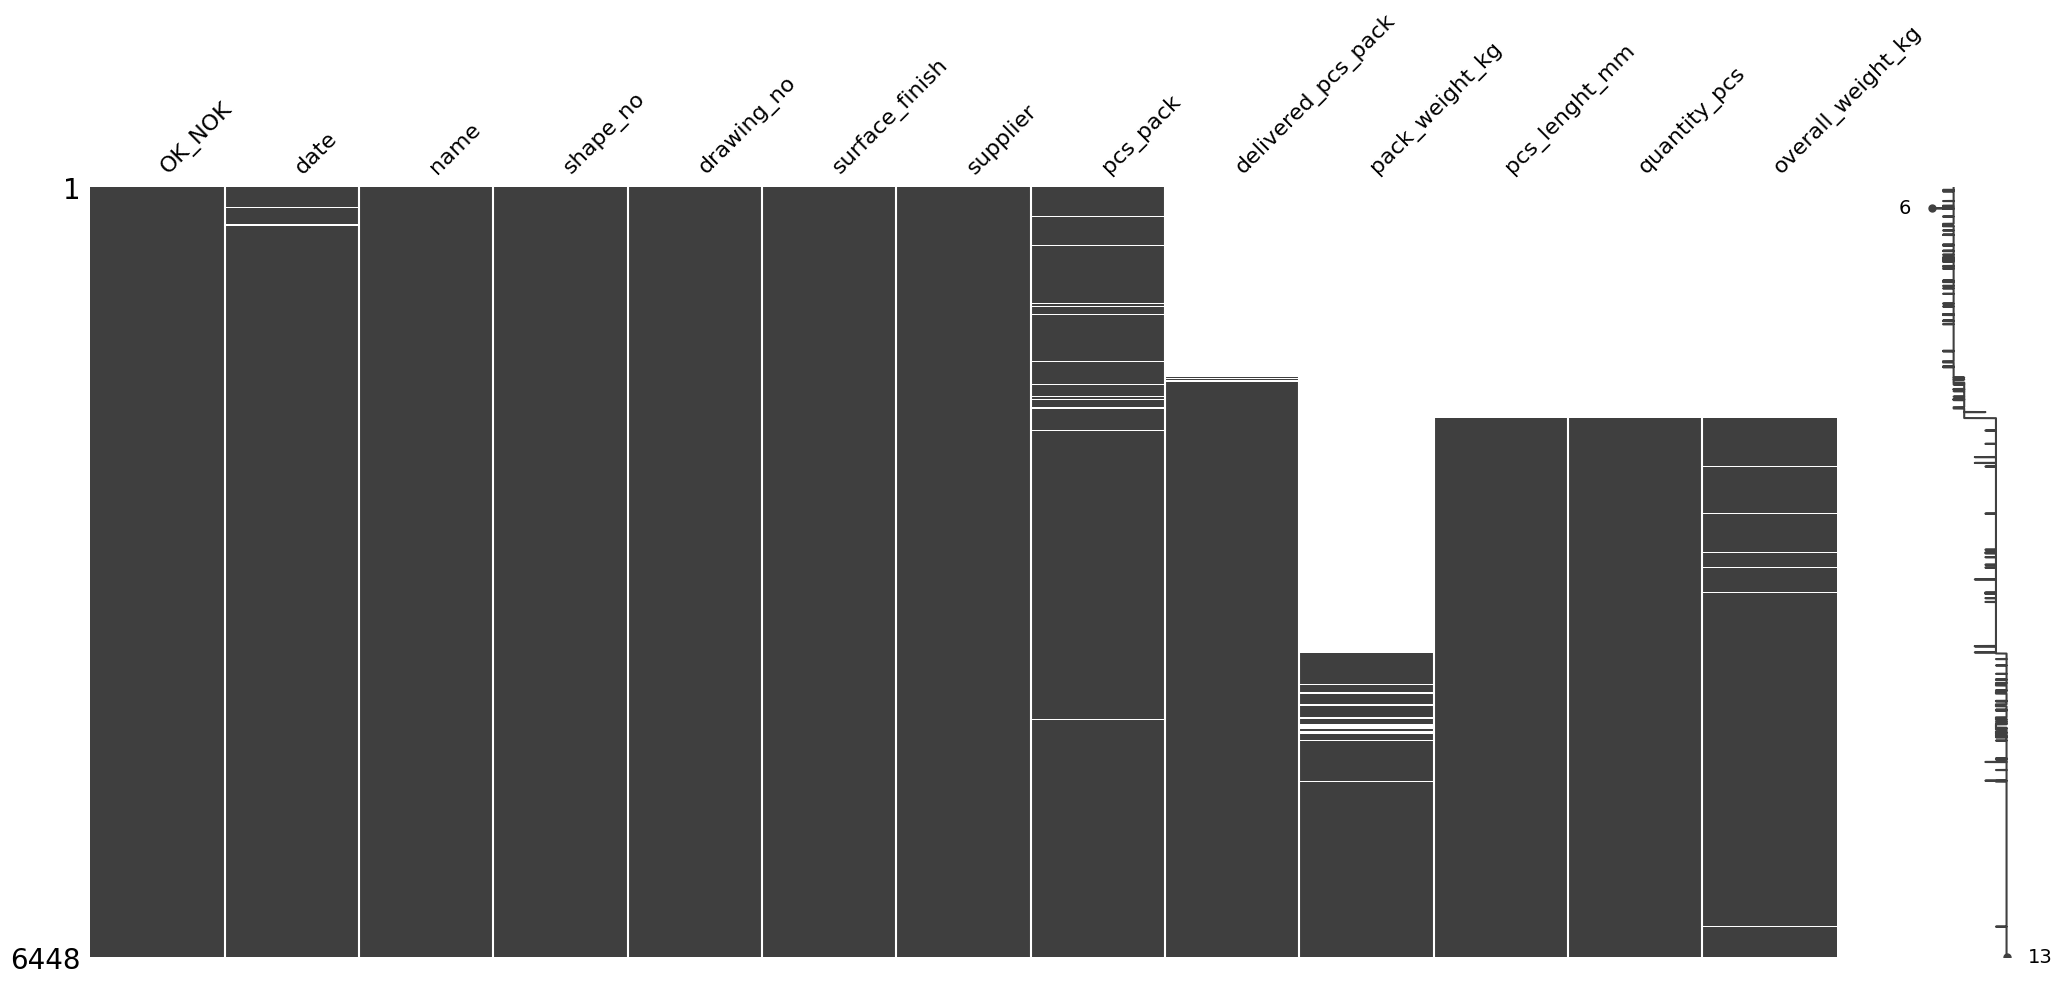

In [28]:
missingno.matrix(df)

<Axes: >

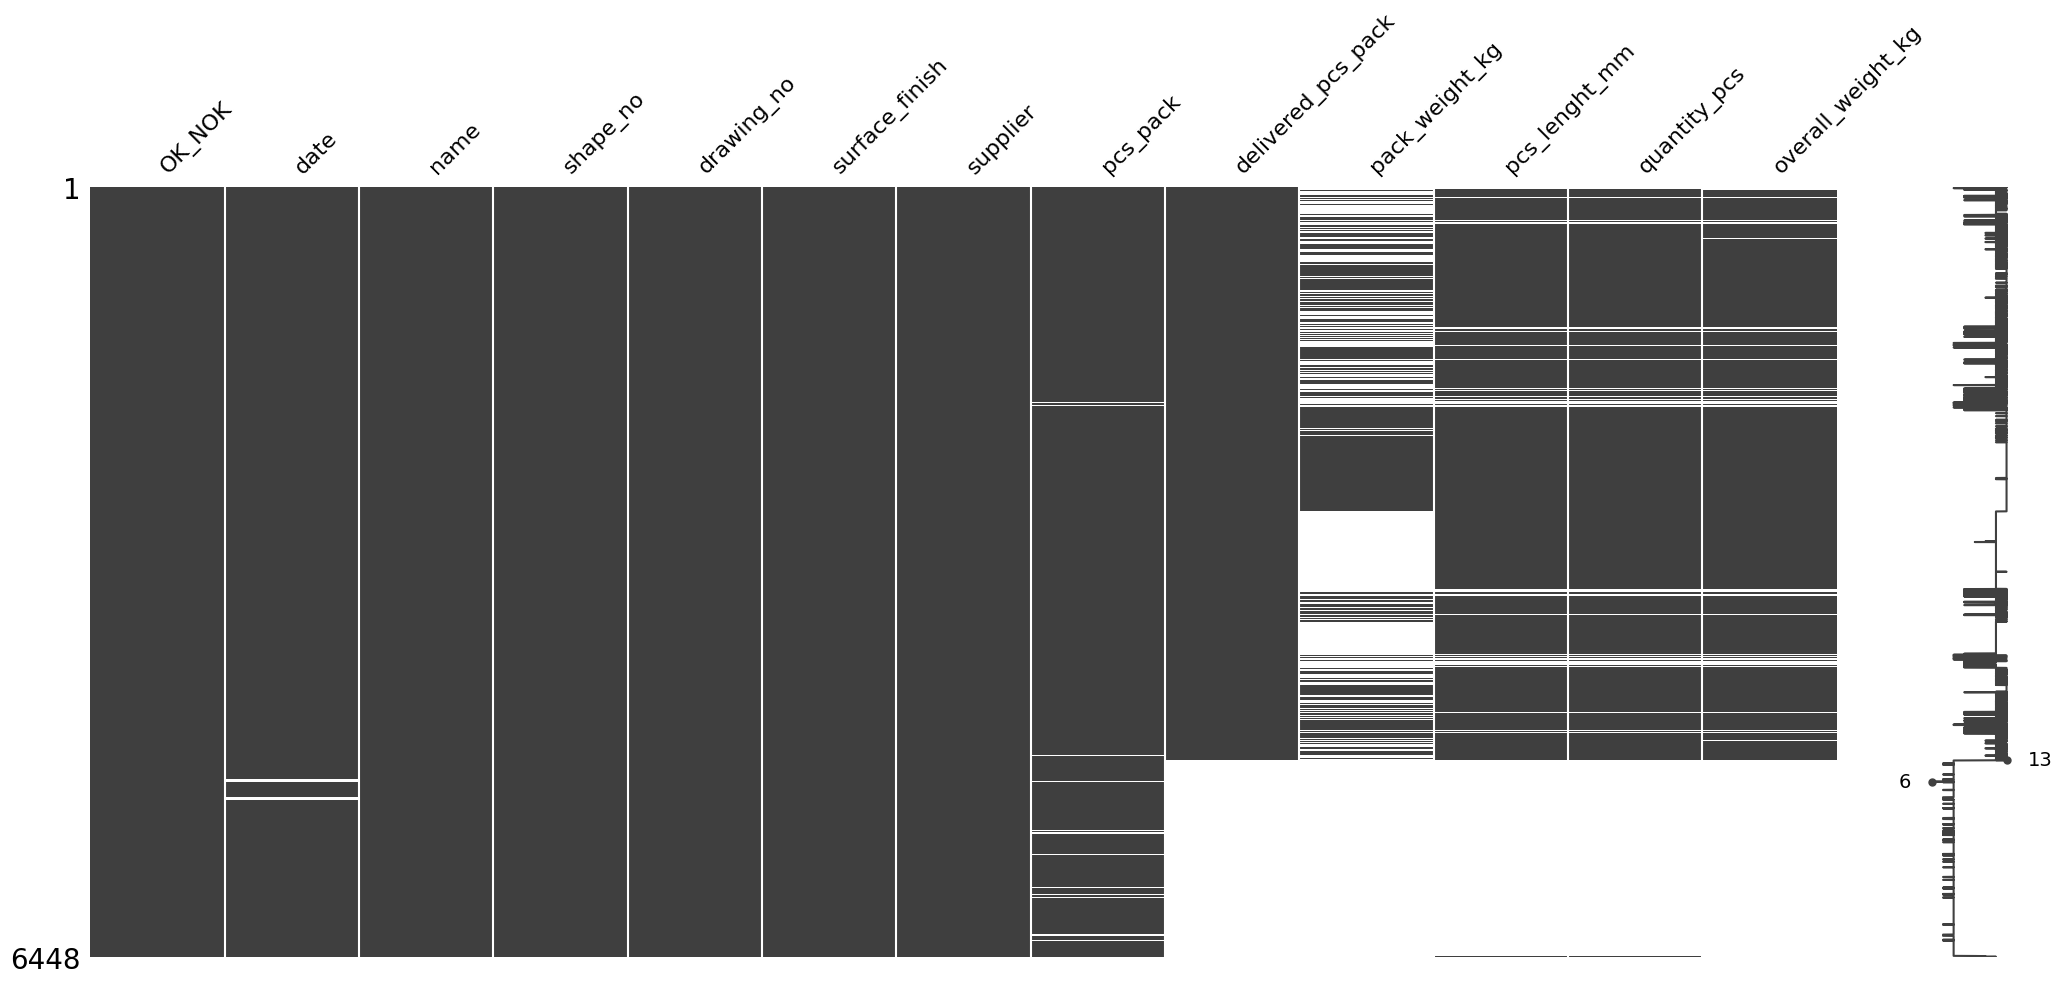

In [29]:
sorted_delivered_pcs_pack = df.sort_values('delivered_pcs_pack')
missingno.matrix(sorted_delivered_pcs_pack)

### 2.6 Data distribution

Since the data is about the delivery of goods some products will be delivered more frequent than others. Let's find out which features make products unique and then check how the products are represented in the dataset by using seaborn count plot.

For choosing unique features we will group the data by name then by drawing number and color.

In [30]:
# filtering a list of unique deliveries.
vc_combo = df[['name','drawing_no', 'surface_finish']].apply(tuple, axis=1).value_counts()
vc_combo

(Vindemiatrix, DR5, color2)     270
(Sargas, DR1, color2)           250
(Lepus, DR0, color2)            237
(Vindemiatrix, DR10, color2)    234
(Sargas, DR20, color2)          205
                               ... 
(Alcyone, DR113, color1)          1
(Monoceros, DR112, color1)        1
(Pegasus2, DR169, color2)         1
(Mirach, DR170, color1)           1
(Delphinus, DR143, color3)        1
Name: count, Length: 352, dtype: int64

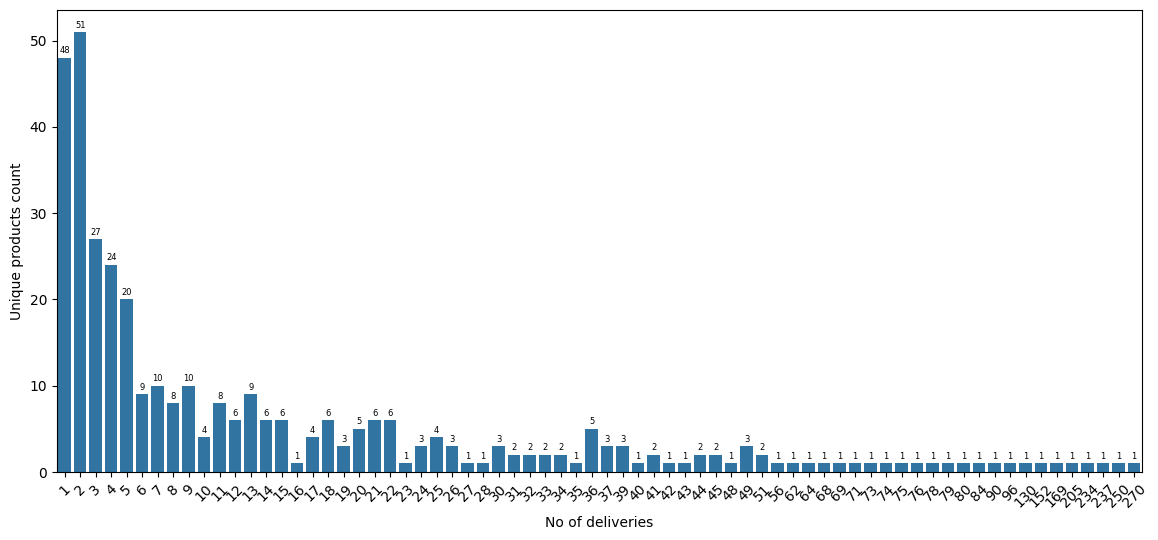

In [31]:
plt.figure(figsize=(14, 6))
ax = sns.countplot(data=df, x=vc_combo)
plt.xlabel('No of deliveries')
plt.ylabel('Unique products count')
plt.xticks(rotation=45);


for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=6, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.show()

Observation:
A notable observation arises from the dataset, revealing a significant cluster of unique deliveries occurring less than 10 times. Several factors could contribute to this phenomenon, such as the introduction of new products, low sales volume items, sporadic deliveries from suppliers (e.g., cargo shipping), or discontinued relationships with underperforming suppliers. Importantly, this observation suggests that predictive modeling based on such sparse data instances may produce unreliable results .

RecommendatioIct, it is recommended to filter out products with fewer than 5 deliveries. This strategic approach aims to bolster the model's robustness by prioritizing more representative data points. Furthermore, it's crucial to thoroughly validate this filtering criterion during model evaluation to ensure its efficacy in enhancing predictive accuracy and generalizabil

From plot we can see that there is at least 150 unique products that were delivered less than 5 times and at this point we wont be able to predict them.ity.y.

As observed in the CatBoost prediction, the dataset reveals a notable class imbalance, with Class 1 being approximately five times more represented than Class 0. This observation aligns with business realities, as an equal distribution of NOK (Not OK) deliveries would impede operational efficiency. However, the presence of 18% NOK deliveries indicates significant room for improvement in the delivery process.

Addressing the high percentage of NOK deliveries presents an opportunity to enhance overall performance and customer satisfaction. Implementing strategies to reduce NOK occurrences, such as refining quality control measures, optimizing supplier relationships, and enhancing delivery logistics, can lead to substantial improvements in business outcomes and stakeholder satisfaction.


In [32]:
ok_nok_vc = df['OK_NOK'].value_counts()
percentage_0 = ok_nok_vc[0] / ok_nok_vc.sum() * 100
percentage_1 = ok_nok_vc[1] / ok_nok_vc.sum() * 100

print(f"Percentage of class 0: {percentage_0:.2f}%")
print(f"Percentage of class 1: {percentage_1:.2f}%")

Percentage of class 0: 18.98%
Percentage of class 1: 81.02%


### 3. Data preprocesing

#### 3.1 Data cleaning - date column

In this section, we performed data cleaning on the 'date' column to prepare it for further analysis. 
We began by inspecting the column's values to identify the variety of formats present, 
which included datetime objects, strings, and NaN values. We then categorized the data types 
and investigated the presence of letters in the string values. 

Subsequently, we created a new column 'date_fmt' to store the cleaned datetime values. 
We converted the string values to datetime format using a consistent date format and addressed 
any remaining NaT (Not a Time) values by manually inspecting and correcting them.

Finally, we verified the results by checking the data types and non-null counts in the 'date_fmt' column. 
These actions ensure that the 'date' column is now suitable for use in subsequent analyses 
without compromising the integrity of the dataset.

In [33]:
df['date'].apply(type).nunique()

3

In [34]:
df['date'].apply(type).value_counts()

date
<class 'datetime.datetime'>    4621
<class 'str'>                  1782
<class 'float'>                  45
Name: count, dtype: int64

In [35]:
df.head(2)

,OK_NOK,date,name,shape_no,drawing_no,surface_finish,supplier,pcs_pack,delivered_pcs_pack,pack_weight_kg,pcs_lenght_mm,quantity_pcs,overall_weight_kg
0,0,"13,01,2017",Lepus,SH0,DR0,color2,SU0,40.00,NaN,NaN,NaN,NaN,NaN
1,0,"13,01,2017",Sargas,SH1,DR1,color2,SU0,40.00,NaN,NaN,NaN,NaN,NaN


In [36]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6448 entries, 0 to 6447
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   OK_NOK              6448 non-null   int64  
 1   date                6403 non-null   object 
 2   name                6448 non-null   object 
 3   shape_no            6448 non-null   object 
 4   drawing_no          6448 non-null   object 
 5   surface_finish      6448 non-null   object 
 6   supplier            6448 non-null   object 
 7   pcs_pack            6350 non-null   float64
 8   delivered_pcs_pack  4801 non-null   float64
 9   pack_weight_kg      2405 non-null   float64
 10  pcs_lenght_mm       4514 non-null   float64
 11  quantity_pcs        4513 non-null   float64
 12  overall_weight_kg   4488 non-null   float64
dtypes: float64(6), int64(1), object(6)
memory usage: 2.6 MB


**Comment**: Let's check last entry, and NaN values:

In [37]:
df.date.iloc[-1]

datetime.datetime(2022, 9, 13, 0, 0)

In [38]:
df.date.isnull().sum()

45

**Comment**: Now I will create new column to check if there are any strings present in date column:

In [39]:
df['is_str'] = df.date.apply(lambda x: True if isinstance(x, str) else False)

In [40]:
df['is_str'].value_counts()

is_str
False    4666
True     1782
Name: count, dtype: int64

**Comment**: As Expected nearly 1,8k rows are strings, lets move the column closer to date column to have a better view, and let's see if those strings contain any letters.

In [41]:
df.insert(2, 'is_str', df.pop('is_str'))


In [42]:
letter_pattern = re.compile(r"[a-zA-Z]")

In [43]:
filter_letter_pattern = df.loc[df['is_str']==True, 'date'].apply(lambda x: True if letter_pattern.search(x) else False)

In [44]:
len(filter_letter_pattern[filter_letter_pattern].index)

54

**Comment**: Out of all elements from date column that are strings 54 contain letters, which isnt that bad considering 1,8k strings.
My approach is to focus on strings that are not letters and try to convert those in to proper datetime format.
I will create new column date_fmt and I will use it to perform all operations there without risking loosing any valid data.

In [45]:
df.loc[df['is_str']==True,'date_fmt'] = df.loc[df['is_str']==True,'date']

In [46]:
df.insert(2, 'date_fmt', df.pop('date_fmt'))

In [47]:
df['date_fmt'] = df.loc[df['is_str']==True,'date_fmt'].str.replace(',', '.').str.replace('/', '.')

In [48]:
df['date_fmt'] = pd.to_datetime(df['date_fmt'], format='%d.%m.%Y', errors='coerce')

In [49]:
df['date_fmt'] = df['date_fmt'].dt.strftime('%Y-%m-%d %H:%M:%S')

**Comment**: Now I will copy over from date column the data that are not strings and convert them to datetime.

In [50]:
df.loc[df['is_str']==False, 'date_fmt'] = pd.to_datetime(df.loc[df['is_str']==False, 'date'], format='%Y-%m-%d %H:%M:%S')

In [51]:
df['date_fmt'] = pd.to_datetime(df['date_fmt'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

**Comment**: After successfully converting the majority of the data to datetime format, the next step involves addressing the remaining NaT (Not a Time) values.

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6448 entries, 0 to 6447
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   OK_NOK              6448 non-null   int64         
 1   date                6403 non-null   object        
 2   date_fmt            6345 non-null   datetime64[ns]
 3   is_str              6448 non-null   bool          
 4   name                6448 non-null   object        
 5   shape_no            6448 non-null   object        
 6   drawing_no          6448 non-null   object        
 7   surface_finish      6448 non-null   object        
 8   supplier            6448 non-null   object        
 9   pcs_pack            6350 non-null   float64       
 10  delivered_pcs_pack  4801 non-null   float64       
 11  pack_weight_kg      2405 non-null   float64       
 12  pcs_lenght_mm       4514 non-null   float64       
 13  quantity_pcs        4513 non-null   float64     

**Comment**: I've opted to manually inspect all remaining NaT (Not a Time) values to retrieve any salvageable data.

In [53]:
original_max_rows = pd.options.display.max_rows

# Temporarily set display options to show all rows
pd.options.display.max_rows = None

# Run the query
result = df.query('date_fmt.isnull()')
# result

In [54]:
df.loc[72, 'date_fmt'] = '2016.10.12'
df.loc[74, 'date_fmt'] = '2016.10.10'
df.loc[233, 'date_fmt'] = '2016.10.12'
df.loc[426, 'date_fmt'] = '2016.03.28'
df.loc[894, 'date_fmt'] = '2018.02.21'
df.loc[1532, 'date_fmt'] = '2018.09.12'
df.loc[1777, 'date_fmt'] = '2018.11.21'
df.loc[1908, 'date_fmt'] = '2018.12.12'

In [55]:
df['date_fmt'] = pd.to_datetime(df['date_fmt'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

In [56]:
pd.options.display.max_rows = original_max_rows

**Comment**: Now, it's time to address the remaining missing data. Given that this table is filled in chronological order and that most of the missing data have low indexes, we can infer that these inspections were likely conducted around 2016.

In [57]:
def random_date(year):
    starting_date = datetime(year, 1, 1)
    stopping_date = datetime(year, 12, 31)
    random_days = randint(0, (stopping_date - starting_date).days)
    return starting_date + timedelta(days=random_days)

In [58]:
df.loc[df['date_fmt'].isnull(), 'date_fmt'] = random_date(2016)

In [59]:
df['date_fmt'].isnull().sum()

0

In [60]:
df.drop(['date', 'is_str'],  axis=1, inplace=True)

**Comment**  I noticed that some dates are set for future occurrences. It seems like this might be because of using the drag-and-drop function in Excel. It looks like someone tried to copy the dates across cells, maintaining the day and month but accidentally changing the year in each cell.

In [61]:
sorted_date_fmt = df.date_fmt.sort_values(ascending=False)
sorted_date_fmt[sorted_date_fmt>'01.01.2023']
sorted_date_fmt_idx = sorted_date_fmt[sorted_date_fmt>'01.01.2023'].index
sorted_date_fmt_idx


Index([1479, 1478, 1477, 1347, 1476, 1346, 1345, 1474, 1344], dtype='int64')

In [62]:
idx_to_change = df.loc[1340:1347].index

In [63]:
idx_to_change2 = df.loc[1470:1479].index

In [64]:
idx_to_change_combined = idx_to_change.append(idx_to_change2)

In [65]:
idx_to_change_combined

Index([1340, 1341, 1342, 1343, 1344, 1345, 1346, 1347, 1470, 1471, 1472, 1473,
       1474, 1475, 1476, 1477, 1478, 1479],
      dtype='int64')

In [66]:
for idx in idx_to_change_combined:
    df.loc[idx, 'date_fmt'] = df.loc[idx, 'date_fmt'].replace(year=int(2018))

### 3.2 Data cleaning - rest of the columns
**Comment**: Fortunately, all string columns have been pre-processed during the encoding process, ensuring data uniformity. This encoding was implemented to render the products unrecognizable, thus complying with legal requirements.

In [67]:
df['name'].apply(type).nunique()

1

In [68]:
df['name'].apply(type).value_counts()

name
<class 'str'>    6448
Name: count, dtype: int64

In [69]:
df['name'] = df['name'].astype(str)

In [70]:
df['shape_no'].apply(type).nunique()

1

In [71]:
df['shape_no'] = df['shape_no'].astype(str)

In [72]:
df['drawing_no'].apply(type).nunique()

1

In [73]:
df['drawing_no'] = df['drawing_no'].astype(str)

In [74]:
df['surface_finish'].apply(type).nunique()

1

In [75]:
df['surface_finish'] = df['surface_finish'].astype(str)

In [76]:
df['supplier'].apply(type).nunique()

1

In [77]:
df['supplier'] = df['supplier'].astype(str)

**Comment**: "The 'quantity_pcs' column represents the volume of each delivery. Generally, quantities below 100 pieces per delivery may indicate special cases like prototype orders, overproduction, or underproduction, rather than standard delivery volumes which usually are much grater. It's crucial to exclude such instances from our model training to prevent bias or inaccuracies. Segregating and excluding these outliers ensures the reliability of our model for analyzing regular deliveries."

In [78]:
quantity_pcs_vc = df['quantity_pcs'] .value_counts()
quantity_pcs_vc
filtered_quantity_pcs_vc = quantity_pcs_vc[quantity_pcs_vc.index<100].sort_values(ascending=False)
row_index_vc = df[df['quantity_pcs'].isin(filtered_quantity_pcs_vc.index)].index
row_index_vc

Index([1953, 1968, 2010, 2063, 2065, 2067, 2079, 2103, 2107, 2123,
       ...
       6362, 6365, 6381, 6383, 6388, 6407, 6422, 6424, 6427, 6434],
      dtype='int64', length=299)

In [79]:
df.drop(row_index_vc, axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

In [80]:
df.loc[4626,'pack_weight_kg'] = float(36.00)

In [81]:
df['pack_weight_kg'] = df['pack_weight_kg'].replace(0, np.nan)

### 4. Filling missing Values

Finding missing values within the dataset by utilizing columns that characterize each record as unique, such as 'drawing_no', 'surface_finish', and 'name'. 

Columns with missing values:

- pack_weight_kg
- pcs_lenght_mm
- delivered_pcs_pack
- pcs_pack
- quantity_pcs

The function `find_missing_vals()` iterates through each index with missing values and searches for matching rows based on the specified unique columns. If matching rows are found, it retrieves corresponding data from the non-null values of the target column, using operations like taking the median or grabbing the first non-null value. This approach ensures that missing values are filled with meaningful data, contributing to the integrity of the dataset.


**Comment** Create a list of indices for each row except for overall_weight_kg which is going to be calculated from data.

In [82]:
pack_weight_null_list = list(df[df['pack_weight_kg'].isnull()].index)
pcs_lenght_mm_null_list = list(df[df['pcs_lenght_mm'].isnull()].index)
delivered_pcs_pack_null_list = list(df[df['delivered_pcs_pack'].isnull()].index)
pcs_pack_null_list = list(df[df['pcs_pack'].isnull()].index)
quantity_pcs_null_list = list(df[df['quantity_pcs'].isnull()].index)

In [83]:
def find_missing_vals(df, column_with_nan, idx_null_list, unique_col1='drawing_no', unique_col2='surface_finish', unique_col3='name', grab='iloc[0]'):
    grab_operations = {
        'iloc[0]': lambda series: series.iloc[0],
        'median': lambda series: series.median(),
        # Add more operations as needed
    }
    for idx in idx_null_list:

        matching_rows = df[(df[unique_col1] == df.loc[idx, unique_col1]) &
                   (df[unique_col2] == df.loc[idx, unique_col2]) &
                   (df[unique_col3] == df.loc[idx, unique_col3]) &
                   (df[column_with_nan].notnull())]

        if not matching_rows.empty:
            corresponding_data = grab_operations[grab](matching_rows[column_with_nan])
            df.loc[idx, column_with_nan] = corresponding_data
        else:
            df.loc[idx, column_with_nan] = np.nan
            

**Comment** Finding missing values within dataset by using  columns that characterize each record as unique.

    * pack_weight_kg
    * pcs_lenght_mm
    * delivered_pcs_pack
    * pcs_pck
    * quantity_pcs

In [84]:
find_missing_vals(df, 'pack_weight_kg', pack_weight_null_list)

In [85]:
find_missing_vals(df, 'pcs_lenght_mm', pcs_lenght_mm_null_list)

In [86]:
find_missing_vals(df, 'delivered_pcs_pack', delivered_pcs_pack_null_list)

In [87]:
find_missing_vals(df, 'pcs_pack', pcs_pack_null_list)

In [88]:
find_missing_vals(df, 'quantity_pcs', quantity_pcs_null_list, grab='median')

In [89]:
df['date_fmt'] = pd.to_datetime(df['date_fmt'])

In [90]:
df.isnull().sum().sort_values(ascending=False)

overall_weight_kg     1948
pack_weight_kg         340
pcs_lenght_mm          168
quantity_pcs           168
pcs_pack                97
delivered_pcs_pack      76
OK_NOK                   0
date_fmt                 0
name                     0
shape_no                 0
drawing_no               0
surface_finish           0
supplier                 0
dtype: int64

**Comment** The "find_missing_vals()" function has successfully filled in the majority of the missing data. Now, it's time to address the remaining NaN's.

**pcs_pck**

Filling missing values in the 'pcs_pack' column by identifying matching rows based on the 'delivered_pcs_pack' column, where 'delivered_pcs_pack' is not null. If matching rows are found, the missing value in 'pcs_pack' is replaced with the value from the first matching row. If no matching rows are found, the missing value is set to NaN. Finally, the mode of the 'pcs_pack' column is used to fill any remaining missing values. This process ensures that missing values in 'pcs_pack' are replaced with appropriate values, enhancing the completeness of the dataset.

In [91]:
pcs_pack_null_list = list(df[df['pcs_pack'].isnull()].index)
len(pcs_pack_null_list)

97

In [92]:
for idx in pcs_pack_null_list:

    matching_rows = df['pcs_pack'][
                                  (df['delivered_pcs_pack'] == df.loc[idx, 'delivered_pcs_pack']) &
                                  (df['delivered_pcs_pack'].notnull())]
    if not matching_rows.empty:
        df.loc[idx, 'pcs_pack'] = matching_rows.iloc[0]
    else:
            df.loc[idx, 'pcs_pack'] = np.nan

In [93]:
pcs_pack_mode = df['pcs_pack'].mode()
df['pcs_pack'] = df['pcs_pack'].fillna(pcs_pack_mode[0])

**delivered_pcs_pack**

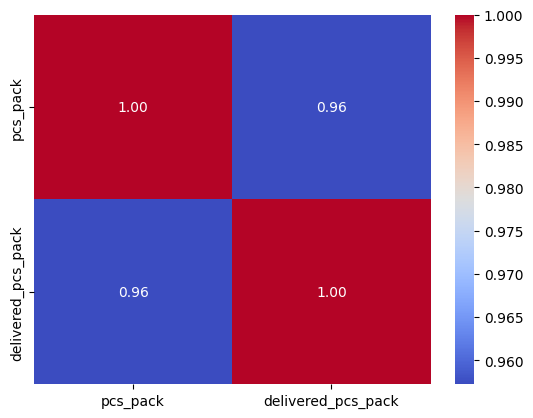

In [94]:
sns.heatmap(df[['pcs_pack', 'delivered_pcs_pack']].corr(),annot=True, fmt='.2f',cmap='coolwarm')
plt.show()

**Commnet** It's observed that 'pcs_pck' and 'delivered_pcs_pack' are nearly identical, suggesting redundancy. I will remove delivered_pcs_pack from the dataset because it contained much more Nan's at the begining.


In [95]:
# df.drop('delivered_pcs_pack', axis=1, inplace=True)

In [96]:
delivered_pcs_pack_null_list = list(df[df['delivered_pcs_pack'].isnull()].index)
len(delivered_pcs_pack_null_list)

76

In [97]:
for idx in delivered_pcs_pack_null_list:

    matching_rows = df['delivered_pcs_pack'][
                                  (df['pcs_pack'] == df.loc[idx, 'pcs_pack']) &
                                  (df['pcs_pack'].notnull())]
    if not matching_rows.empty:
        df.loc[idx, 'delivered_pcs_pack'] = matching_rows.iloc[0]
    else:
            df.loc[idx, 'delivered_pcs_pack'] = np.nan

In [98]:
delivered_pcs_pack_mode = df['delivered_pcs_pack'].mode()
df['delivered_pcs_pack'] = df['delivered_pcs_pack'].fillna(delivered_pcs_pack_mode[0])

In [99]:
df['delivered_pcs_pack'].isnull().sum()

0

**pack_weight_kg**

In [100]:
len(df[(df['pack_weight_kg'].isnull())])

340

In [101]:
pack_weight_kg_median = df['pack_weight_kg'].median()
pack_weight_kg_median

27.2

**Comment:** After filtering the DataFrame `df`, we can still find sufficient data to compute the missing values for the 'pack_weight_kg' column. Specifically, there are 67 records where the necessary information is available. We will calculate these values by dividing the 'overall_weight_kg' by the 'quantity_pcs' and then multiplying the result by 'delivered_pcs_pack'.

In [102]:
len(df[(df['pack_weight_kg'].isnull()) & (df['overall_weight_kg'].notnull()) &  (df['overall_weight_kg'] != 0) & (df['pcs_pack'].notnull())])

67

In [103]:
pack_weight_null_list = list(df[df['pack_weight_kg'].isnull()].index)

In [104]:
# Iterate over the indices of rows with missing values in 'overal_weight_kg'
for idx in pack_weight_null_list:
    # Extract necessary values from the DataFrame
    quantity_pcs = df.loc[idx, 'quantity_pcs']
    overall_weight_kg = df.loc[idx, 'overall_weight_kg']
    pcs_pack = df.loc[idx,'pcs_pack']
    
    # Calculate corresponding overall weight
    if overall_weight_kg != 0 and pcs_pack != 0 and quantity_pcs != 0:
        compute_pack_weight = (overall_weight_kg / quantity_pcs) * pcs_pack
        # Assign the calculated overall weight to the corresponding row in 'overal_weight_kg' column
        df.loc[idx, 'pack_weight_kg'] = compute_pack_weight

In [105]:
len(df[(df['pack_weight_kg'].isnull())])

273

**Comment** This is as far as i can go to find missing values, the rest would have to be inputed by the median, but insted of using median on all values I will input the median value for each indyvidual "delivered_pck' column.

In [106]:
pack_weight_null_list = list(df[df['pack_weight_kg'].isnull()].index)

In [107]:
for idx in pack_weight_null_list:
    matching_rows = df['pack_weight_kg'][
                                  (df['pcs_pack'] == df.loc[idx, 'pcs_pack']) &
                                  (df['pcs_pack'].notnull())]  
    if not matching_rows.empty:
        df.loc[idx, 'pack_weight_kg'] = matching_rows.median()       
    else:
            df.loc[idx, 'pack_weight_kg'] = np.nan           

In [108]:
print(len(df[(df['pack_weight_kg'].isnull())]))
len(df[(df['pack_weight_kg']==0)])

0


0

**pcs_lenght_mm**

In [109]:
pcs_lenght_mm_mode = df['pcs_lenght_mm'].mode()[0]
df['pcs_lenght_mm'] = df['pcs_lenght_mm'].fillna(pcs_lenght_mm_mode)

In [110]:
df['pcs_lenght_mm'].isnull().sum()

0

**quantity_pcs**

In [111]:
quantity_pcs_median = df['quantity_pcs'].median().astype(int)
df['quantity_pcs'] = df['quantity_pcs'].fillna(quantity_pcs_median)
df['quantity_pcs'].isnull().sum()

0

**overall_weight_kg**

**Comment** The 'overall_weight_kg' column contains NaNs and zeroes, which shouldn't be filled with median values. Doing so could potentially result in misleading information since the overall weight primarily depends on the quantity and weight of individual packets. Fortunately, we have both of these features available. Instead of using a median, let's devise a logic to recalculate the weight for each sample based on its individual packet quantities and weights.

In [112]:
overall_weight_kg_na_idx = df.loc[(df['overall_weight_kg'].isnull()) | (df['overall_weight_kg']== 0)].index

In [113]:
# Iterate over the indices of rows with missing values in 'overal_weight_kg'
for idx in overall_weight_kg_na_idx:
    # Extract necessary values from the DataFrame
    quantity_pcs = df.loc[idx, 'quantity_pcs']
    pcs_pck = df.loc[idx, 'pcs_pack']
    pack_weight_kg = df.loc[idx,'pack_weight_kg']
    
    # Calculate corresponding overall weight
    corresponding_overal_weight = (quantity_pcs / pcs_pck) * pack_weight_kg
    
    # Assign the calculated overall weight to the corresponding row in 'overal_weight_kg' column
    df.loc[idx, 'overall_weight_kg'] = corresponding_overal_weight

**Comment**: Additionaly its better to change units from millimeters and kilograms to meters and tonnes.

In [114]:
for idx, row in df.iterrows():
    # Extract values from the current row
    lenght_mm = row['pcs_lenght_mm']
    weight_kg = row['overall_weight_kg']
    # Convert length and weight to meters and kilograms, respectively
    converted_lenght = lenght_mm / 1000
    converted_weight = weight_kg / 1000

    df.loc[idx, 'pcs_lenght_mm'] = converted_lenght
    df.loc[idx, 'overall_weight_kg'] = converted_weight

In [115]:
df = df.rename(columns={'pcs_lenght_mm' : 'pcs_lenght_m', 'overall_weight_kg': 'overall_weight_t'})


In [116]:
df.isnull().sum().sort_values(ascending=False)

OK_NOK                0
date_fmt              0
name                  0
shape_no              0
drawing_no            0
surface_finish        0
supplier              0
pcs_pack              0
delivered_pcs_pack    0
pack_weight_kg        0
pcs_lenght_m          0
quantity_pcs          0
overall_weight_t      0
dtype: int64

**Comment** The Nan values has been handeld therefore, I opted to store the result in a new modified DataFrame (modified_df).

In [117]:
df.to_csv('modified_dataframe.csv', index=False)

In [118]:
dtype = {'date_fmt': 'datetime64[ns]'}
modified_df = pd.read_csv('modified_dataframe.csv', parse_dates=['date_fmt'])

### 5 Outliers

In [119]:
def detect_outliers(df, n, features):
    outlier_indices=[]
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        outlier_step = 1.75 * IQR
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)
    outlier_indices = Counter(outlier_indices)
    
    multiple_outliers = list(key for key, value in outlier_indices.items() if value > n)
    return (multiple_outliers)

outliers_to_drop = detect_outliers(modified_df, 0, ['pack_weight_kg','quantity_pcs', 'overall_weight_t'])
print("We will drop these {} indices: ".format(len(outliers_to_drop)), outliers_to_drop)


We will drop these 172 indices:  [336, 340, 919, 1233, 1234, 1275, 1612, 1689, 2230, 2996, 3800, 4437, 4464, 4756, 4758, 4887, 5011, 5014, 5016, 5020, 5021, 5022, 5082, 5148, 5500, 5501, 5552, 5863, 5867, 5868, 5869, 1643, 1653, 2007, 2024, 2025, 2036, 2130, 2136, 2138, 2181, 2188, 2270, 2274, 2335, 2360, 2364, 2365, 2431, 2505, 2709, 2772, 2845, 2893, 2908, 3067, 3188, 3241, 3252, 3280, 3282, 3383, 3387, 3389, 3422, 3493, 3571, 3582, 3654, 3690, 3697, 3818, 3939, 4118, 4232, 4388, 4445, 4804, 4805, 4915, 4918, 4944, 5023, 5161, 5162, 5403, 5430, 5472, 5762, 5780, 5825, 5864, 5872, 5879, 75, 85, 228, 240, 241, 264, 288, 294, 341, 344, 345, 366, 367, 403, 405, 491, 492, 496, 497, 498, 510, 586, 595, 596, 613, 685, 686, 732, 735, 749, 758, 854, 855, 856, 857, 858, 1084, 1090, 1091, 1175, 1178, 1183, 1184, 1187, 1276, 1277, 1300, 1303, 1340, 1343, 1347, 1450, 1515, 1596, 1601, 1618, 1619, 1621, 1622, 1623, 1645, 1779, 1794, 1869, 1874, 1875, 2021, 2231, 2379, 2458, 2595, 3010, 3467, 4056,

In [120]:
df_outliers_to_drop = modified_df.loc[outliers_to_drop]

In [121]:
print('Before droping training set has {} rows'.format(len(modified_df)))
modified_df = modified_df.drop(outliers_to_drop, axis=0).reset_index(drop=True)
print('After droping training set has {} rows'.format(len(modified_df)))

Before droping training set has 6149 rows
After droping training set has 5977 rows


### 6 Feature analysis
     6.1 Numerical values:
     * "pcs_pck",
     * "pcs_lenght_mm",
     * "overall_weight_kg",
     * "quantity_pcs",
     * "pack_weight_kg",

**Comment** Before we begin to anylise the dataset let's remove those unique deliveries that occured less than 5 times.

In [122]:
# Group by the three columns and count occurrences
combo_counts = modified_df.groupby(['drawing_no', 'surface_finish', 'name']).size()

# Filter combinations with counts less than 5
filtered_combos = combo_counts[combo_counts < 5].index

# Filter the DataFrame based on the filtered combinations
modified_df = modified_df[~modified_df[['drawing_no', 'surface_finish', 'name']].apply(tuple, axis=1).isin(filtered_combos)]


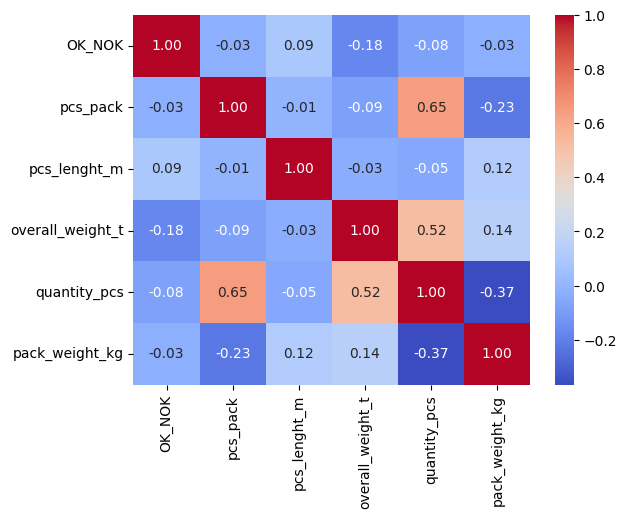

In [123]:
g = sns.heatmap(modified_df[["OK_NOK","pcs_pack", "pcs_lenght_m", "overall_weight_t", "quantity_pcs","pack_weight_kg"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

**Comment**: While it appears that no feature exhibits a significant linear correlation with the target feature, it's important to note that this doesn't render the features useless. Subgroups within these features may still exhibit correlations with survival rates. To ascertain this, a detailed exploration of these features is necessary.

**pcs_pck**

In [124]:
modified_df['pcs_pack'].value_counts()

pcs_pack
40.00     2860
20.00     1609
100.00     517
60.00      338
10.00      264
25.00       35
50.00       28
80.00        5
Name: count, dtype: int64

In [125]:
pcs_pack_vc = modified_df['pcs_pack'].value_counts()

In [126]:
modified_df[['pcs_pack', 'OK_NOK']].groupby('pcs_pack', as_index=False).mean().sort_values('OK_NOK', ascending=False)

,pcs_pack,OK_NOK
4,50.00,1.00
0,10.00,0.85
1,20.00,0.85
5,60.00,0.85
7,100.00,0.81
2,25.00,0.80
3,40.00,0.77
6,80.00,0.60


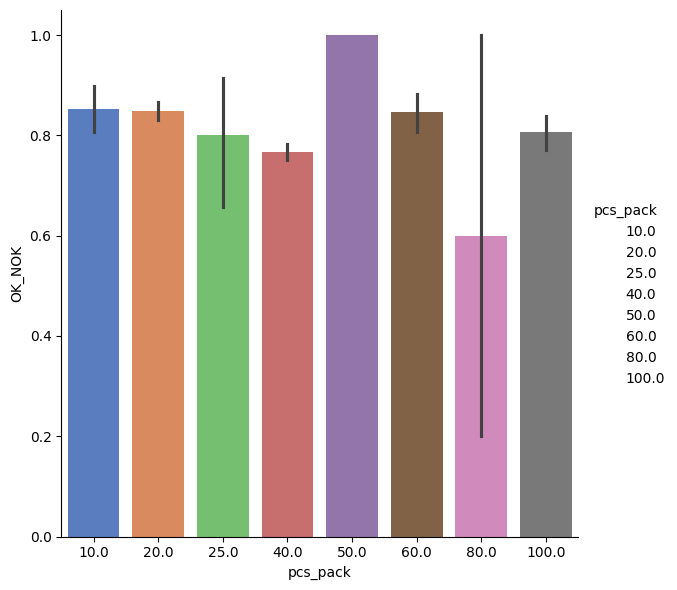

In [127]:
sns.catplot(x='pcs_pack', y='OK_NOK', data=modified_df, kind="bar", height=6, palette="muted")
plt.show()

**Comment** : The 'pcs_pck' numerical feature displays imbalance, skewness, and potentially large value ranges, which might impact predictive model performance. To tackle these issues, scaling the feature can help normalize its distribution and mitigate the influence of its skewed nature. 

In [128]:
modified_df['pcs_pack'] = modified_df['pcs_pack'].apply(lambda x: np.log(x) if x > 0 else 0)

In [129]:
from sklearn.preprocessing import MinMaxScaler

pcs_pack_scaler = MinMaxScaler()

reshaped_pcs_pck = modified_df['pcs_pack'].values.reshape(-1,1)
modified_df['pcs_pack'] = pcs_pack_scaler.fit_transform(reshaped_pcs_pck)

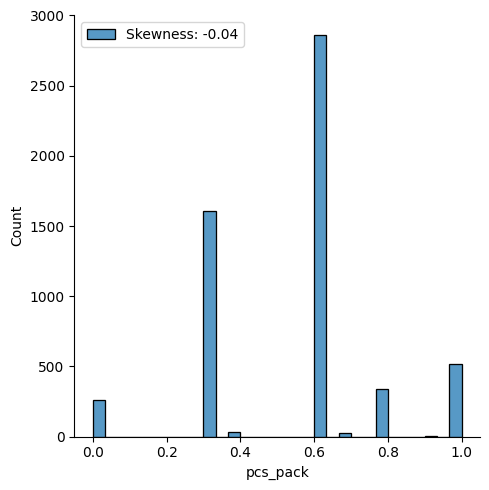

In [130]:
sns.displot(data=modified_df, x='pcs_pack', kind='hist', label='Skewness: %.2f'%(modified_df['pcs_pack'].skew()))
plt.legend(loc='best')
plt.show()

**pcs_lenght_m**

pcs_lenght_m_bin

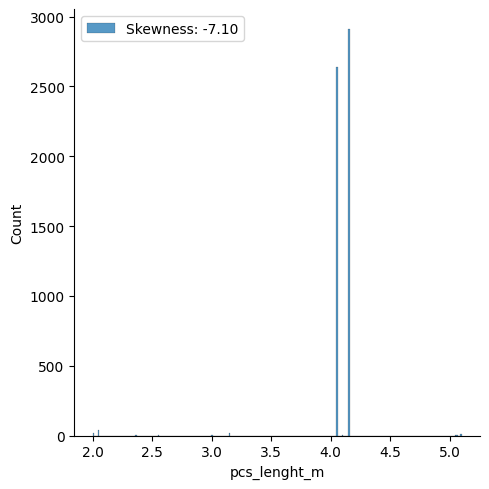

In [131]:
sns.displot(data=modified_df, x='pcs_lenght_m', kind='hist', label='Skewness: %.2f'%(modified_df['pcs_lenght_m'].skew()))
plt.legend(loc='best')
plt.show()

**Comment** From distribiution plot we can see that pcs_lenght_m column has 2 dominant values and therefore is more categorical than numerical feature.

In [132]:
pcs_lenght_m_vc = modified_df['pcs_lenght_m'].value_counts()
filterd_pcs_lenght_m_vc = pcs_lenght_m_vc[pcs_lenght_m_vc<1000]
pcs_lenght_m_vc

pcs_lenght_m
4.15    2909
4.05    2641
2.05      42
2.00      20
3.15      17
5.10       8
3.00       6
5.06       4
2.55       4
5.05       2
2.37       2
4.10       1
Name: count, dtype: int64

In [133]:
 modified_df['pcs_lenght_m_bin'] =  modified_df['pcs_lenght_m'].apply(lambda x: 'Other_lenght' if x in filterd_pcs_lenght_m_vc else str(x))

In [134]:
 modified_df['pcs_lenght_m_bin'].value_counts()

pcs_lenght_m_bin
4.15            2909
4.05            2641
Other_lenght     106
Name: count, dtype: int64

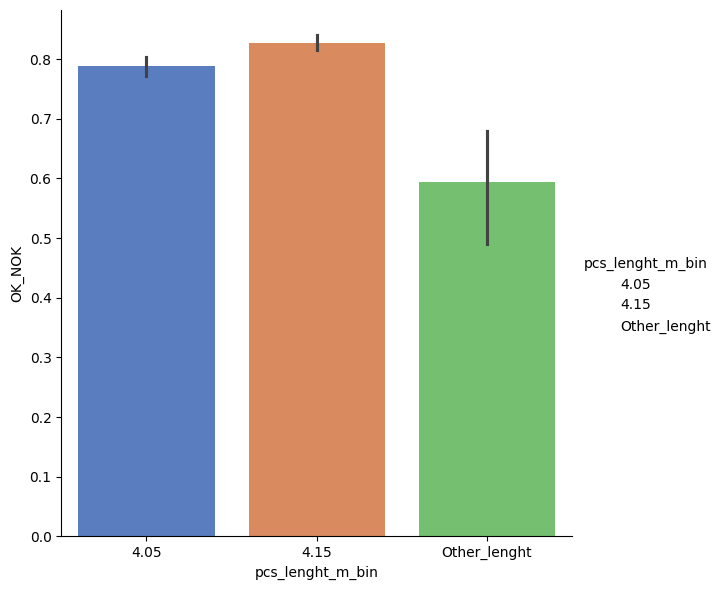

In [135]:
sns.catplot(x='pcs_lenght_m_bin', y='OK_NOK', data=modified_df, kind="bar", height=6, palette="muted")
plt.show()

In [136]:
modified_df.drop('pcs_lenght_m', axis=1, inplace=True)
modified_df.reset_index(drop=True, inplace=True)

**overall_weight_t**

overall_weight_t_bin

In [137]:
weight_vc = modified_df['overall_weight_t'].value_counts()
weight_vc

overall_weight_t
0.78    129
0.73     93
0.75     86
0.63     76
0.78     68
       ... 
0.75      1
0.48      1
0.19      1
0.51      1
0.53      1
Name: count, Length: 2625, dtype: int64

In [138]:
overall_weight_t_scaler = MinMaxScaler()

reshaped_overall_weight_t = modified_df['overall_weight_t'].values.reshape(-1,1)
modified_df['overall_weight_t'] = overall_weight_t_scaler.fit_transform(reshaped_overall_weight_t)

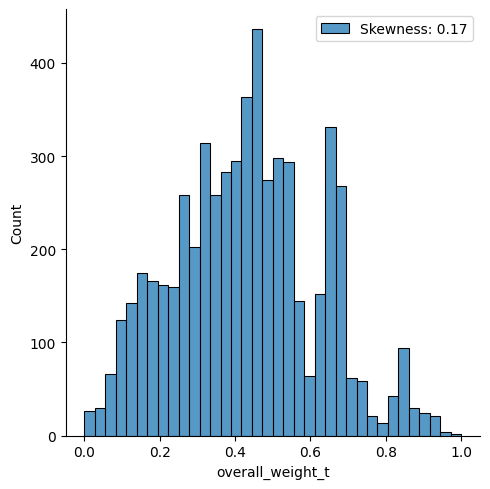

In [139]:
sns.displot(data=modified_df, x='overall_weight_t', kind='hist', label='Skewness: %.2f'%(modified_df['overall_weight_t'].skew()))
plt.legend(loc='best')
plt.show()

**Comment** Next we add bins feature

In [140]:
modified_df['overall_weight_t_bin'] = pd.cut(modified_df['overall_weight_t'], bins=5)

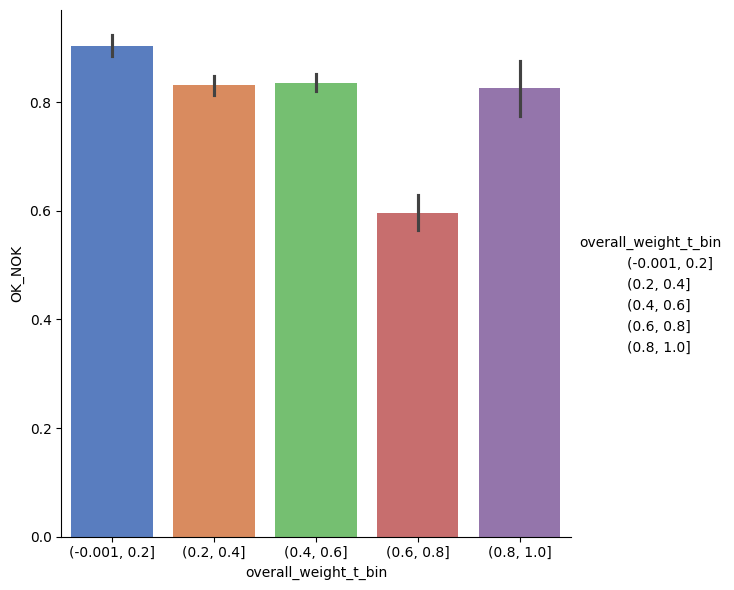

In [141]:
sns.catplot(x='overall_weight_t_bin', y='OK_NOK', data=modified_df, kind="bar", height=6, palette="muted")
plt.show()

In [142]:
modified_df.drop('overall_weight_t', axis=1, inplace=True)
modified_df.reset_index(drop=True, inplace=True)

**quantity_pcs**

quantity_pcs_bin

In [143]:
modified_df['quantity_pcs'].value_counts().sort_values(ascending=False)

quantity_pcs
360.00     159
1150.00    142
1175.00    131
600.00     121
288.00     107
          ... 
1739.00      1
133.00       1
2040.00      1
869.00       1
2032.00      1
Name: count, Length: 885, dtype: int64

In [144]:
quantity_pcs_scaler = MinMaxScaler()

reshaped_quantity_pcs = modified_df['quantity_pcs'].values.reshape(-1,1)
modified_df['quantity_pcs'] = quantity_pcs_scaler.fit_transform(reshaped_quantity_pcs)

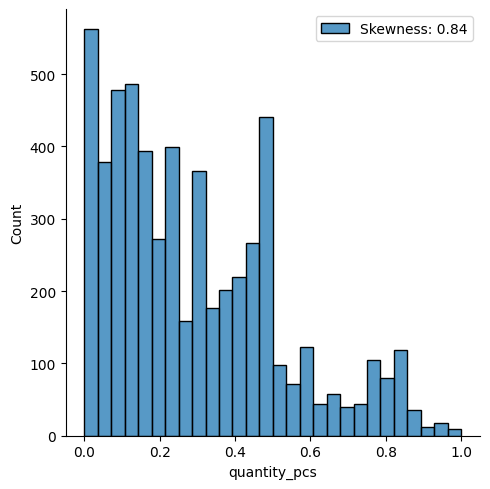

In [145]:
sns.displot(data=modified_df, x='quantity_pcs', kind='hist', label='Skewness: %.2f'%(modified_df['quantity_pcs'].skew()))
plt.legend(loc='best')
plt.show()

**Comment** Quantity is better represented as categorical feature.

In [146]:
modified_df['quantity_pcs_bin'] = pd.cut(modified_df['quantity_pcs'], bins=5)

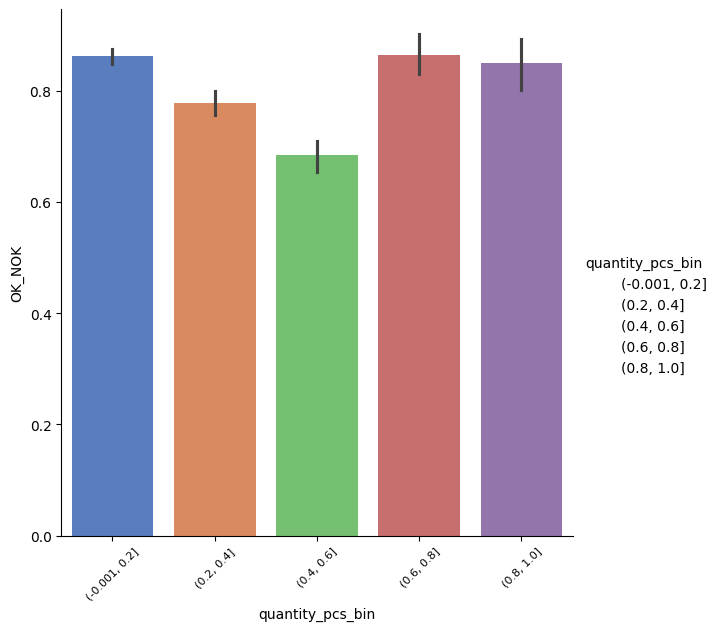

In [147]:
quantity_bin_plot = sns.catplot(x='quantity_pcs_bin', y='OK_NOK', data=modified_df, kind="bar", height=6, palette="muted")
quantity_bin_plot.set_xticklabels(rotation=45, fontsize=8)
plt.show()

In [148]:
modified_df.drop('quantity_pcs', axis=1, inplace=True)
modified_df.reset_index(drop=True, inplace=True)

**pack_weight_kg**

In [149]:
modified_df['pack_weight_kg'].value_counts().sort_values(ascending=False)

pack_weight_kg
26.60    306
26.10    272
23.70    229
27.00    226
23.00    209
        ... 
11.50      1
37.20      1
44.80      1
41.80      1
12.20      1
Name: count, Length: 223, dtype: int64

**Comment** Add bin feature

In [150]:
pack_weight_scaler = MinMaxScaler()

reshaped_pcs_pck = modified_df['pack_weight_kg'].values.reshape(-1,1)
modified_df['pack_weight_kg'] = pack_weight_scaler.fit_transform(reshaped_pcs_pck)

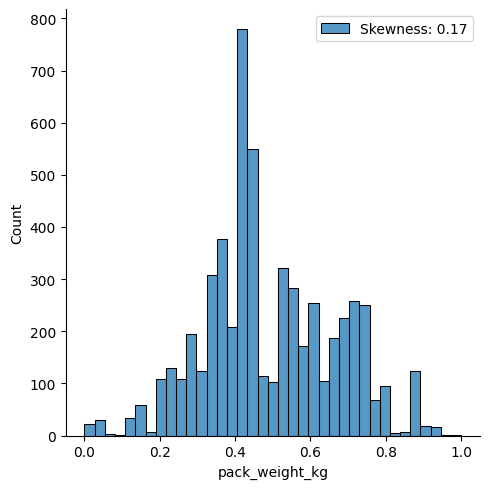

In [151]:
sns.displot(data=modified_df, x='pack_weight_kg', kind='hist', label='Skewness: %.2f'%(modified_df['pack_weight_kg'].skew()))
plt.legend(loc='best')
plt.show()

In [152]:
modified_df['pack_weight_kg_bin'] = pd.cut(modified_df['pack_weight_kg'], bins=5)

In [153]:
pack_weight_bin_vc = modified_df['pack_weight_kg_bin'].value_counts()
pack_weight_bin_vc

pack_weight_kg_bin
(0.4, 0.6]       2383
(0.2, 0.4]       1448
(0.6, 0.8]       1349
(0.8, 1.0]        254
(-0.001, 0.2]     222
Name: count, dtype: int64

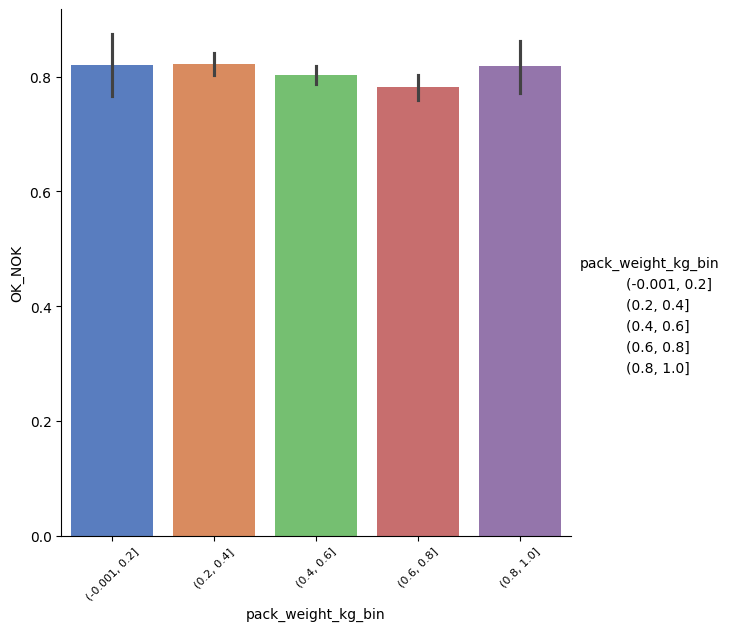

In [154]:
pack_weight_bin_plot = sns.catplot(x='pack_weight_kg_bin', y='OK_NOK', data=modified_df, kind="bar", height=6, palette="muted")
pack_weight_bin_plot.set_xticklabels(rotation=45, fontsize=8)
plt.show()

In [155]:
modified_df.drop('pack_weight_kg_bin', axis=1, inplace=True)
modified_df.reset_index(drop=True, inplace=True)

### 5.2 Categorical features
    *name
    *shape_no
    *drawing_no
    *surface_finish
    *supplier
    
    


**name**

In [156]:
name_vc = modified_df['name'].value_counts()
name_vc

name
Vindemiatrix    520
Sargas          449
Lepus           419
Cygnus2         119
Caelum          118
               ... 
Kaus              5
Andromeda1        5
Scheat            5
Crux              5
Phecda            5
Name: count, Length: 150, dtype: int64

In [157]:
name_prob_ok_nok = modified_df.groupby('name')['OK_NOK'].mean()
name_order = name_prob_ok_nok.sort_values().index

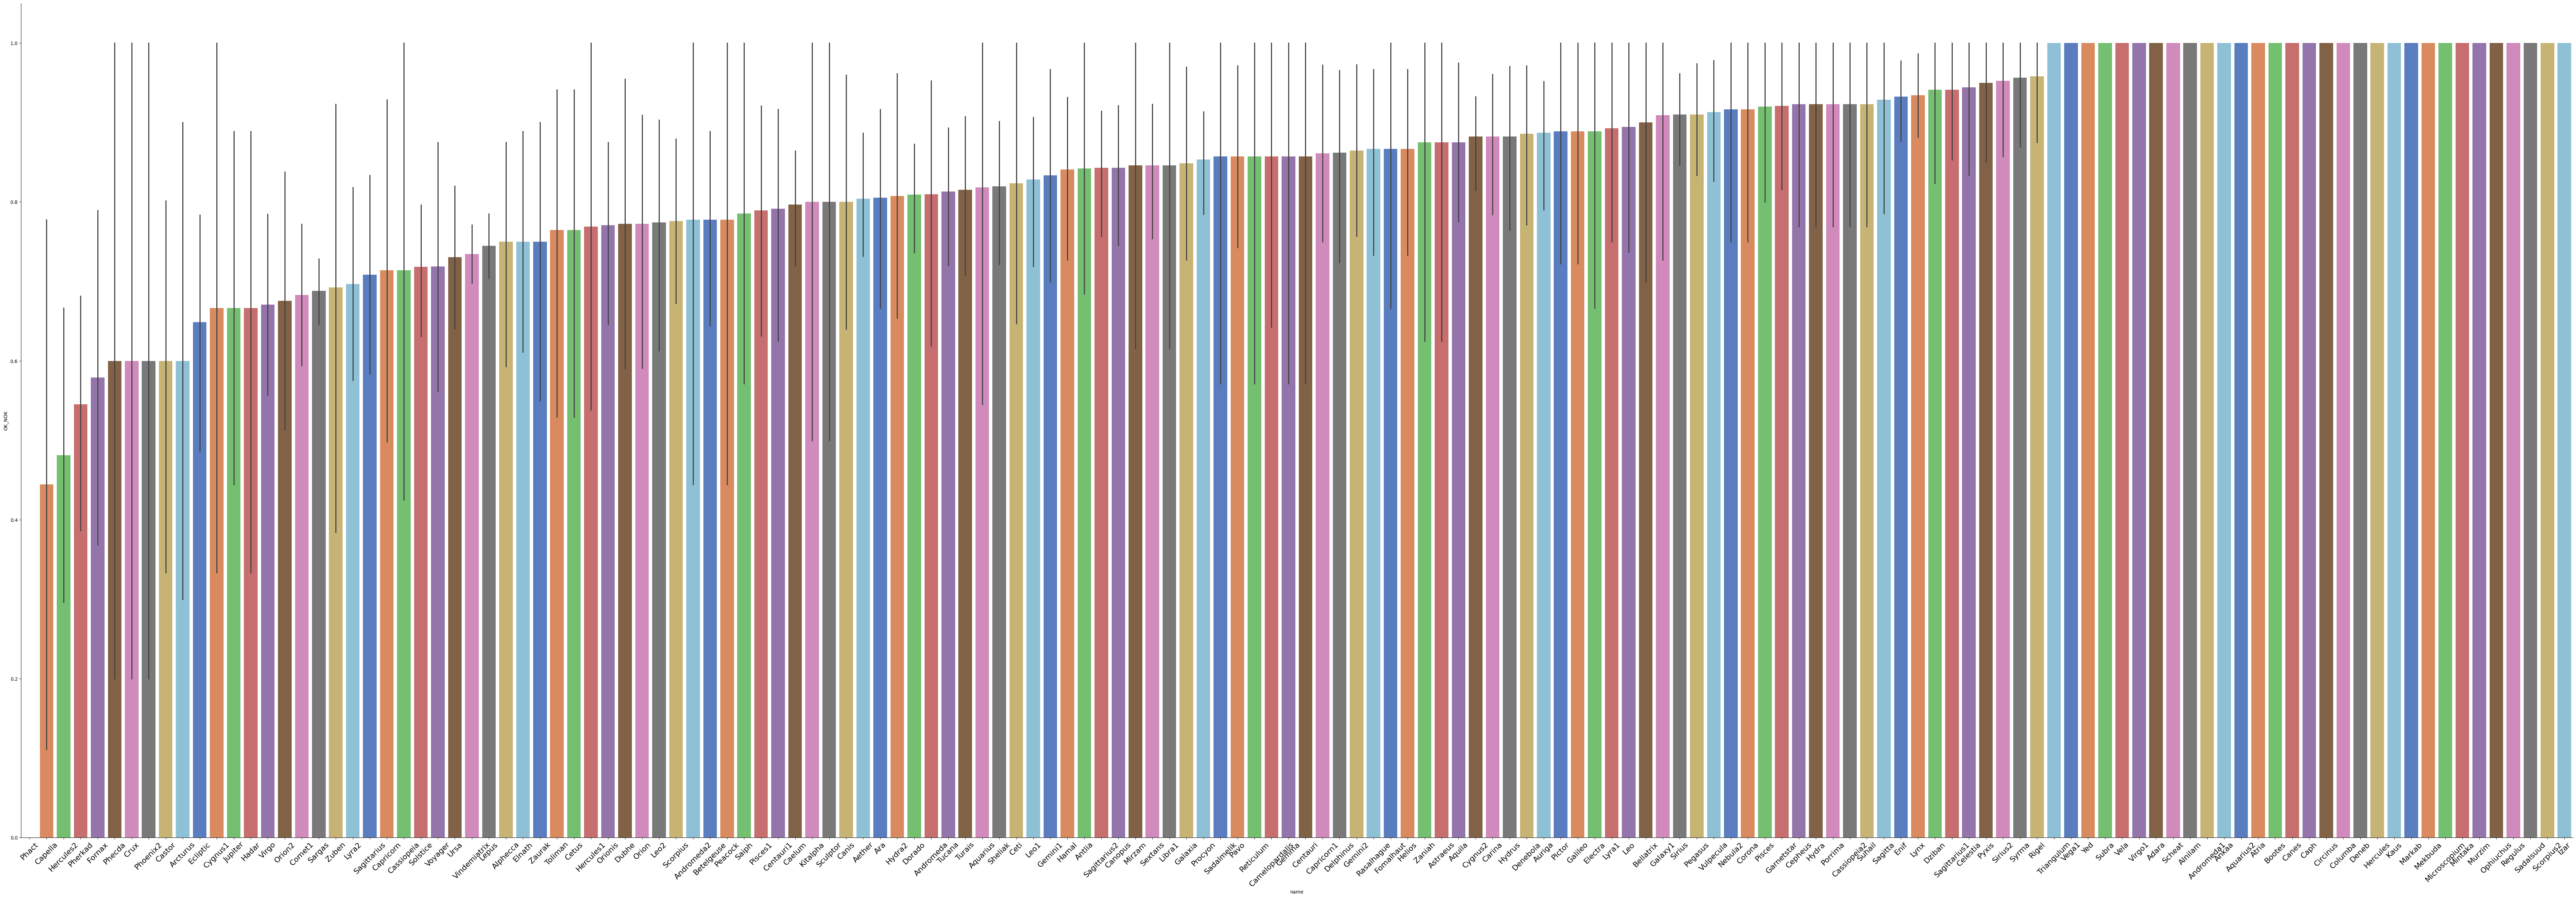

In [158]:
name_plot = sns.catplot(x='name', y='OK_NOK', data=modified_df, kind="bar", height=25, aspect=3, palette="muted", order=name_order, legend=False)
name_plot.set_xticklabels(rotation=45, fontsize=16)
plt.show()

**shape_no**

In [159]:
shape_no_vc = modified_df['shape_no'].value_counts()
# filtered_shape_no_vc_35 = shape_no_vc[shape_no_vc<=35]


In [160]:
shape_no_prob_ok_nok = modified_df.groupby('shape_no')['OK_NOK'].mean()
shape_no_order = shape_no_prob_ok_nok.sort_values().index

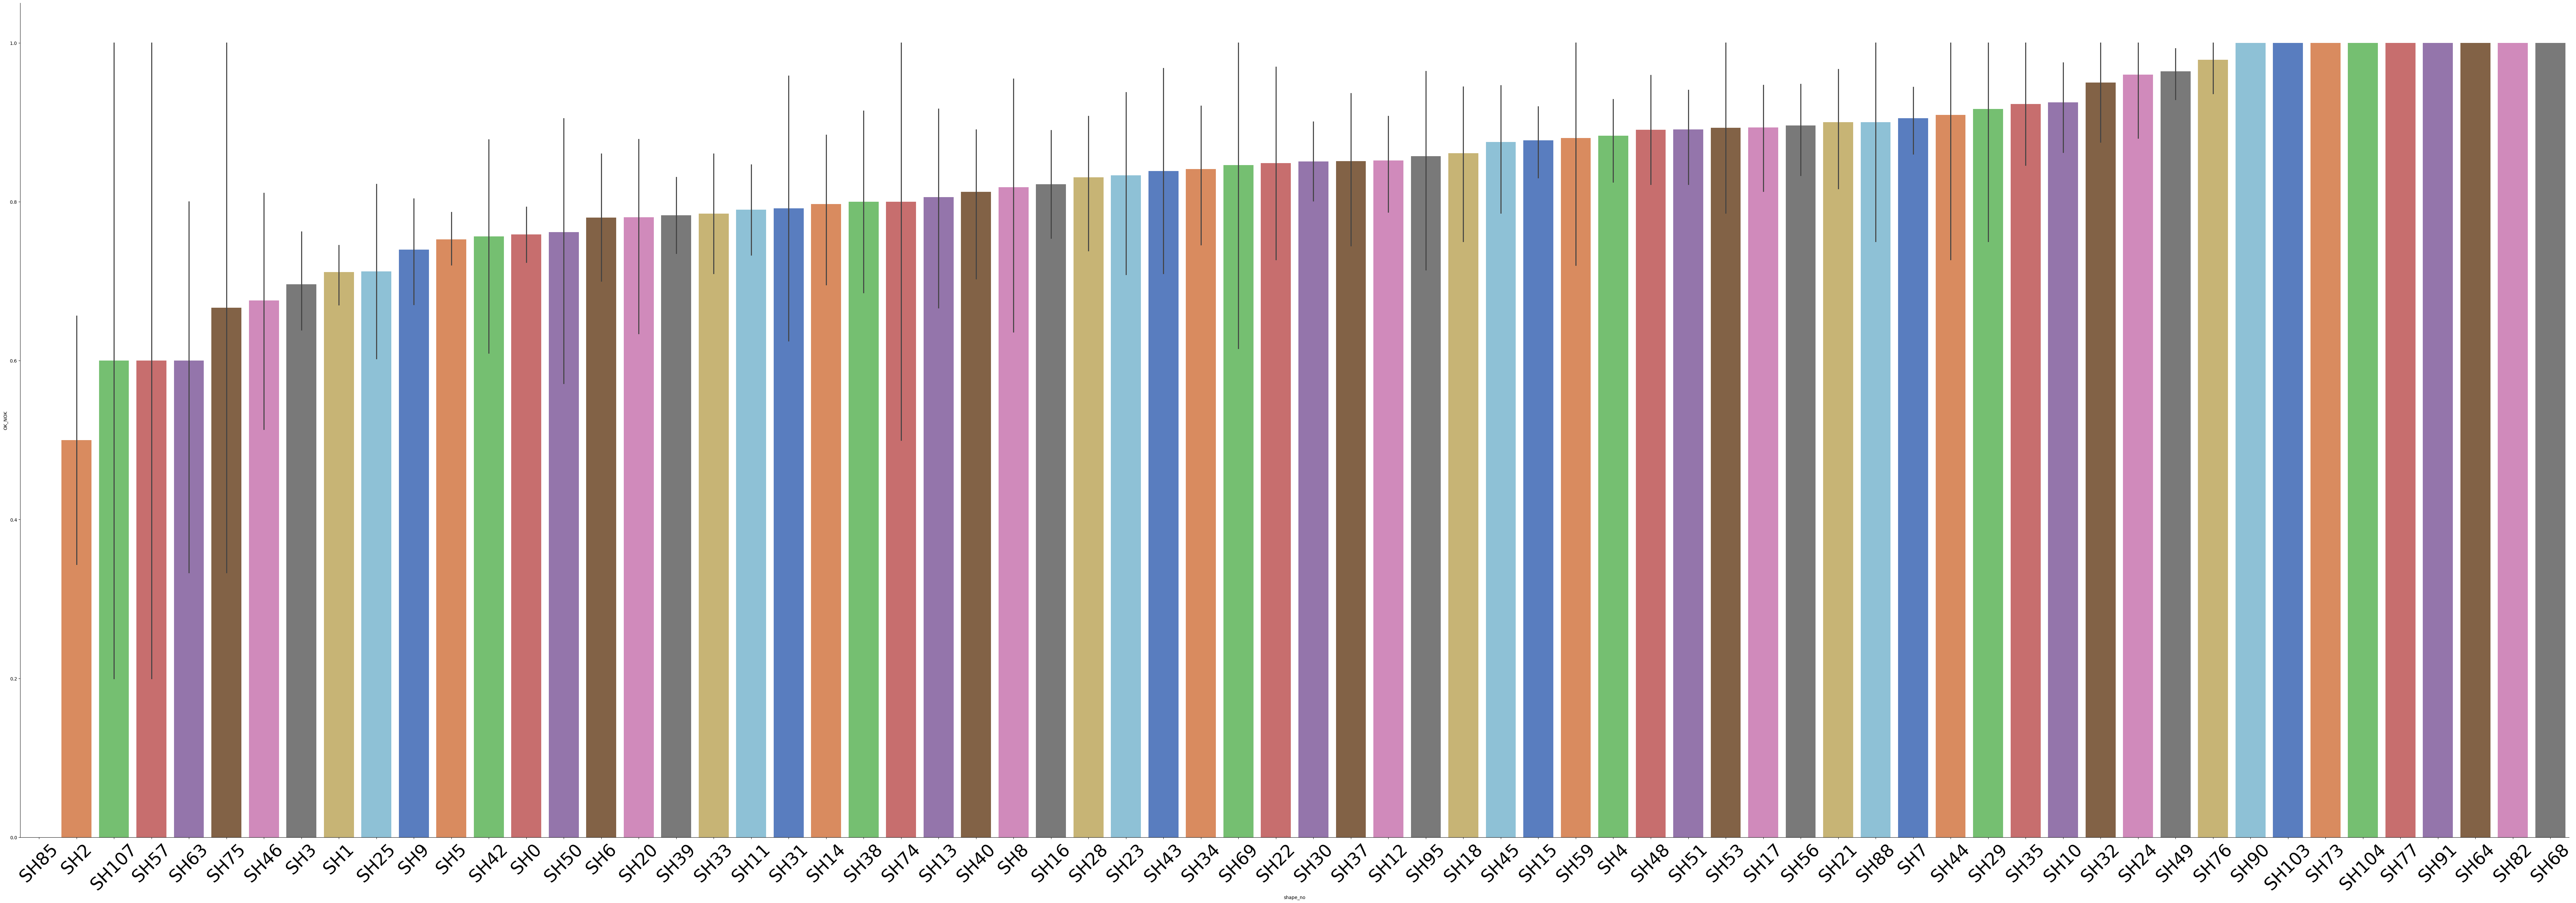

In [161]:
shape_no_plot = sns.catplot(x='shape_no', y='OK_NOK', data=modified_df, kind="bar", height=26, aspect=3, palette="muted", order=shape_no_order, legend=False)
shape_no_plot.set_xticklabels(rotation=45, fontsize=38)
plt.show()

**drawing_no**

In [162]:
drawing_no_vc = modified_df['drawing_no'].value_counts()


In [163]:
drawing_no_prob_ok_nok = modified_df.groupby('drawing_no')['OK_NOK'].mean()
drawing_no_order = drawing_no_prob_ok_nok.sort_values().index

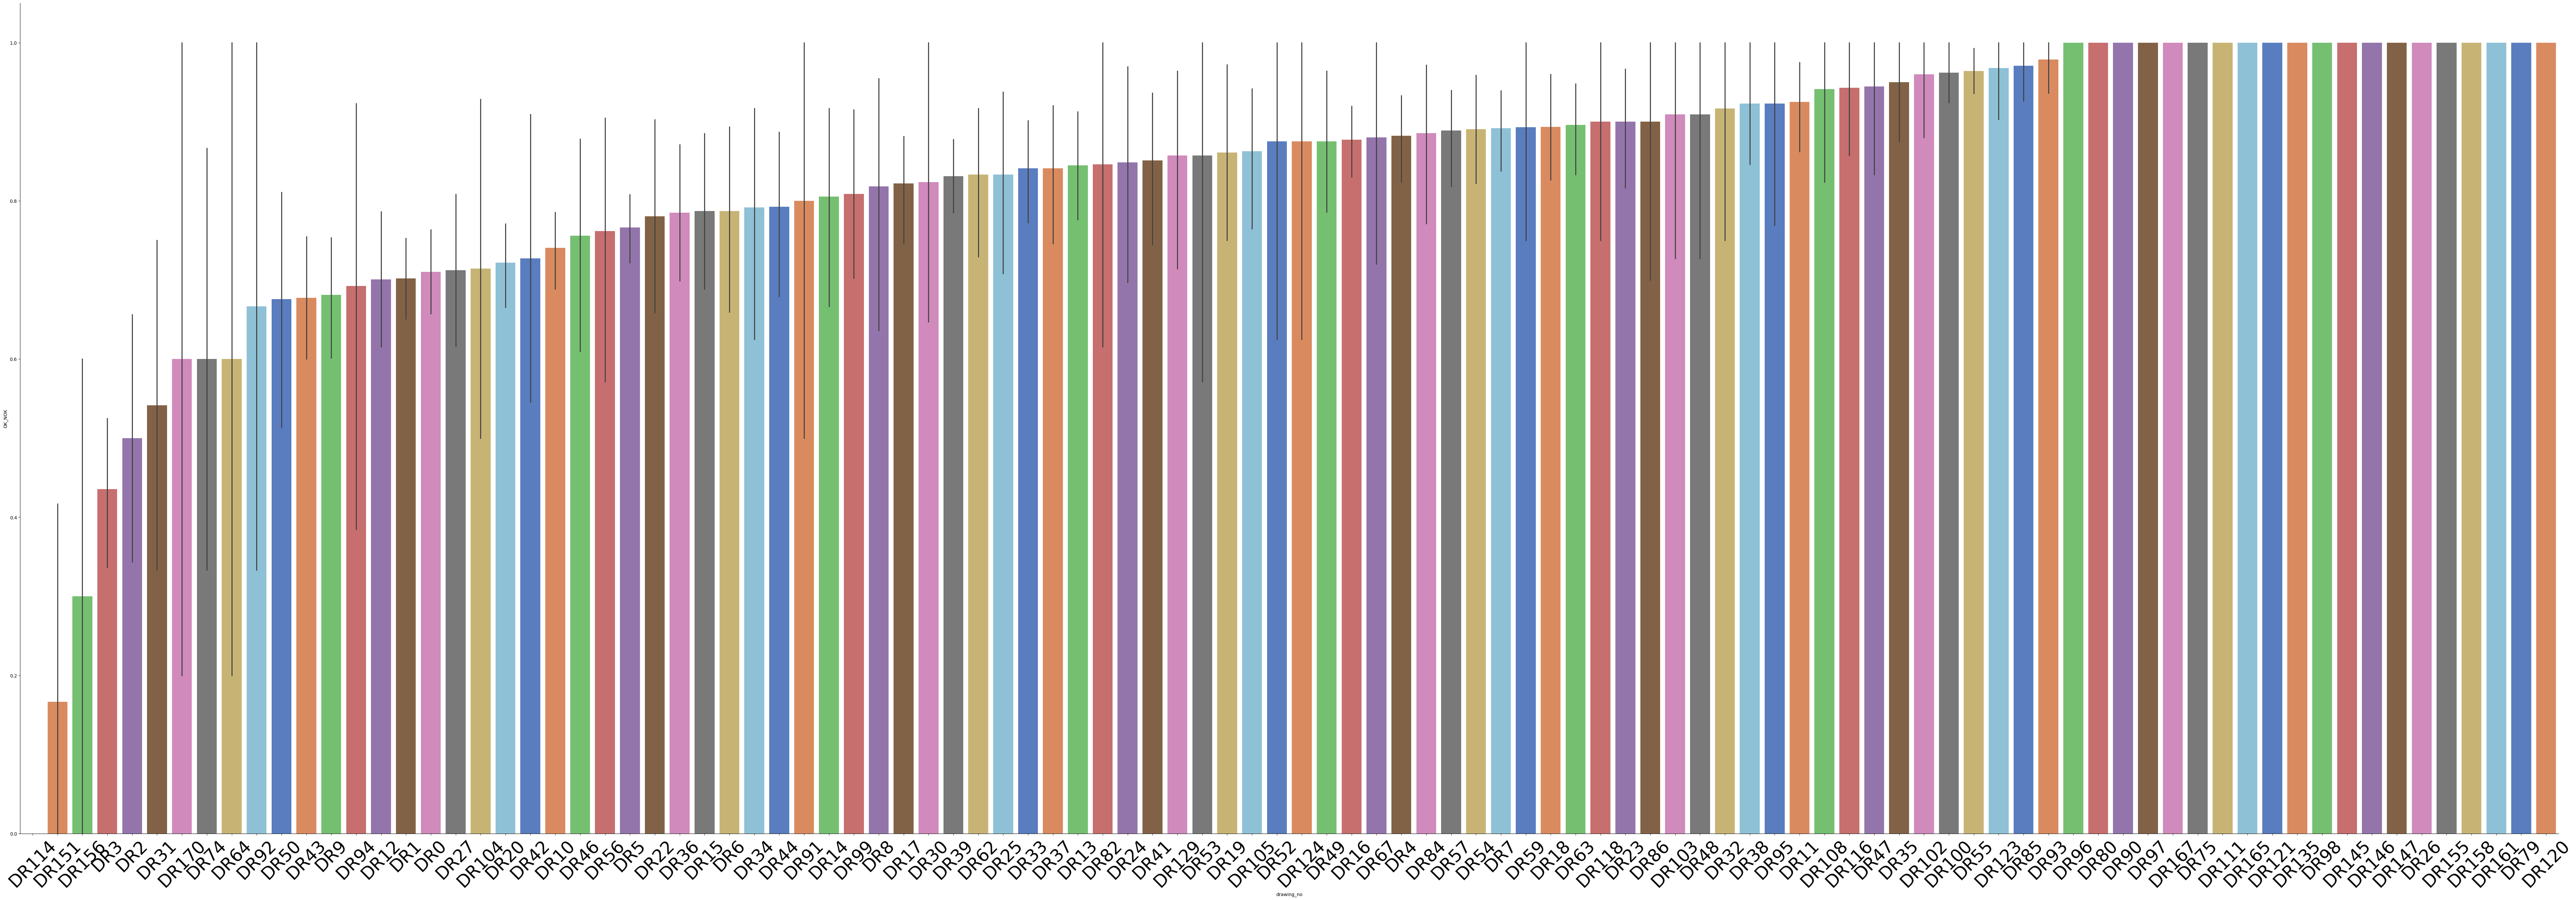

In [164]:
drawing_no_order_plot = sns.catplot(x='drawing_no', y='OK_NOK', data=modified_df, kind="bar", height=26, aspect=3, palette="muted", order=drawing_no_order, legend=False)
drawing_no_order_plot.set_xticklabels(rotation=45, fontsize=38)
plt.show()

**surface_finish**

In [165]:
surface_finish_vc = modified_df['surface_finish'].value_counts()
surface_finish_vc

surface_finish
color2    3579
color1    1455
color3     616
BIAŁY        6
Name: count, dtype: int64

In [166]:
modified_df = modified_df[modified_df['surface_finish'] != "BIAŁY"]

In [167]:
surface_finish_prob_ok_nok = modified_df.groupby('surface_finish')['OK_NOK'].mean()
surface_finish_order = surface_finish_prob_ok_nok.sort_values().index
surface_finish_prob_ok_nok

surface_finish
color1   0.87
color2   0.78
color3   0.79
Name: OK_NOK, dtype: float64

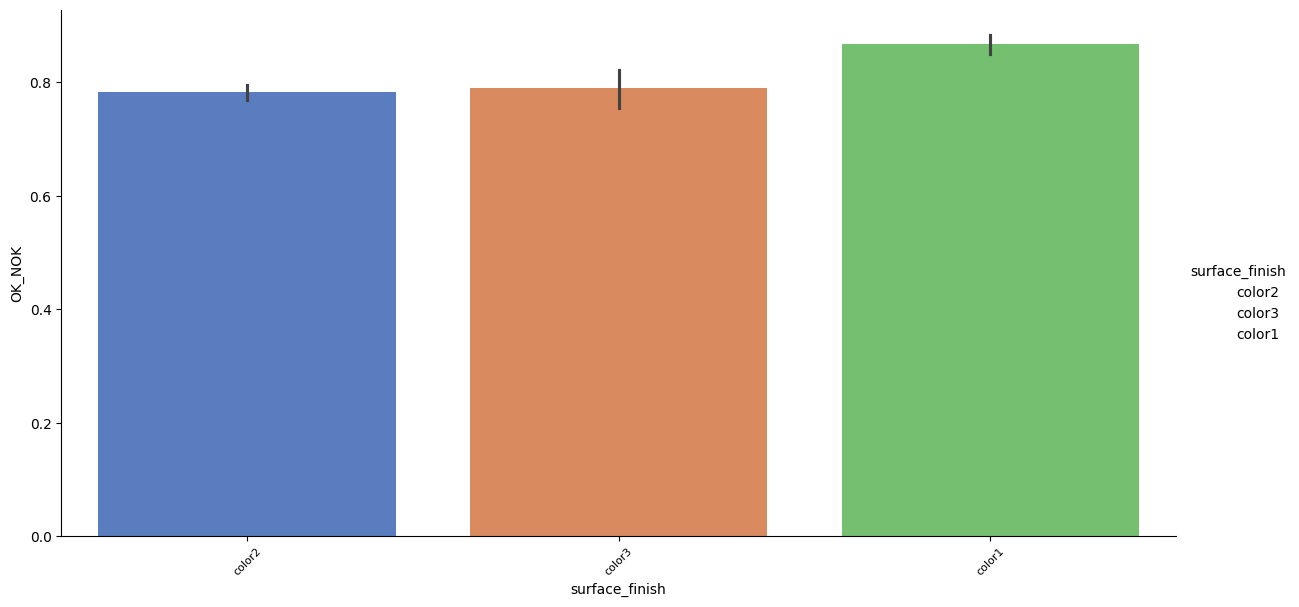

In [168]:
surface_finish_plot = sns.catplot(x='surface_finish', y='OK_NOK', data=modified_df, kind="bar", height=6, aspect=2, palette="muted", order=surface_finish_order,)
surface_finish_plot.set_xticklabels(rotation=45, fontsize=8)
plt.show()

**supplier**

In [169]:
supplier_vc = modified_df['supplier'].value_counts()
supplier_vc

supplier
SU1    3871
SU0    1597
SU2     131
SU5      20
SU6      12
SU3      10
SU4       9
Name: count, dtype: int64

In [170]:
supplier_prob_ok_nok = modified_df.groupby('supplier')['OK_NOK'].mean()
supplier_order = supplier_prob_ok_nok.sort_values().index

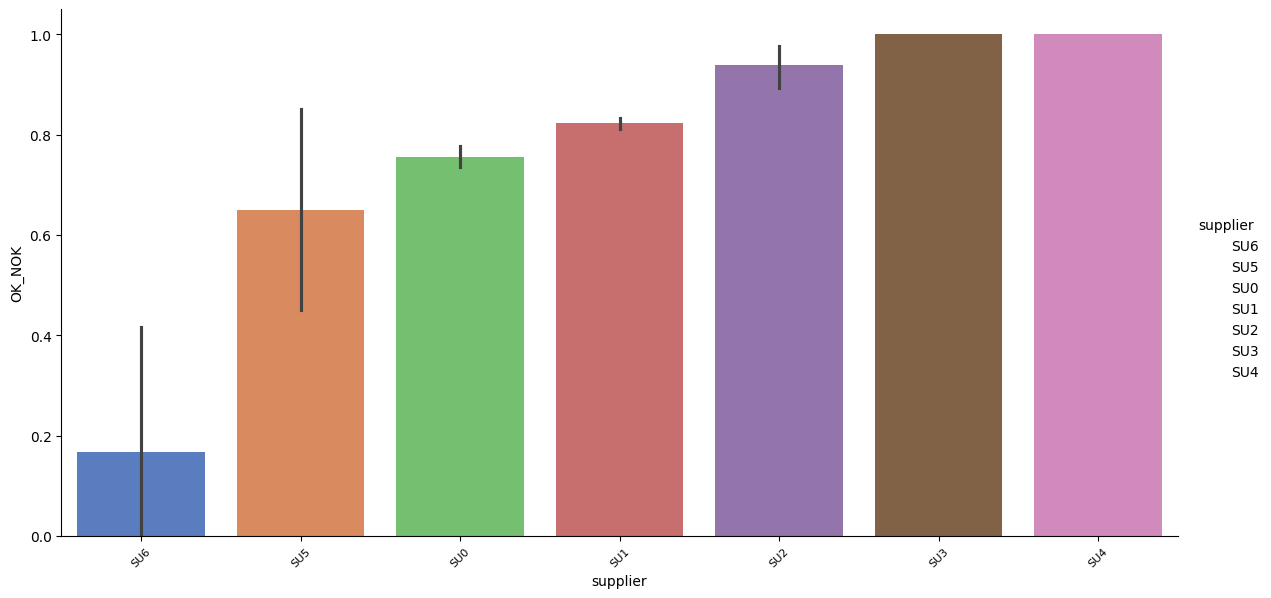

In [171]:
supplier_plot = sns.catplot(x='supplier', y='OK_NOK', data=modified_df, kind="bar", height=6, aspect=2, palette="muted", order=supplier_order,)
supplier_plot.set_xticklabels(rotation=45, fontsize=8)
plt.show()

**Comment** One hot encoding features

In [172]:
modified_df.head()

,OK_NOK,date_fmt,name,shape_no,drawing_no,surface_finish,supplier,pcs_pack,delivered_pcs_pack,pack_weight_kg,pcs_lenght_m_bin,overall_weight_t_bin,quantity_pcs_bin
0,0,2017-01-13,Lepus,SH0,DR0,color2,SU0,0.60,50.00,0.35,4.05,"(0.4, 0.6]","(0.4, 0.6]"
1,0,2017-01-13,Sargas,SH1,DR1,color2,SU0,0.60,40.00,0.75,4.15,"(0.6, 0.8]","(0.2, 0.4]"
2,0,2017-01-13,Lepus,SH0,DR0,color2,SU0,0.60,50.00,0.35,4.05,"(0.4, 0.6]","(0.4, 0.6]"
3,0,2017-01-13,Lepus,SH0,DR0,color2,SU0,0.60,50.00,0.35,4.05,"(0.4, 0.6]","(0.4, 0.6]"
4,0,2017-01-19,Hercules2,SH2,DR2,color2,SU1,0.60,40.00,0.22,4.15,"(0.2, 0.4]","(0.2, 0.4]"


In [173]:
modified_df.query('date_fmt > "2017.01.01" and date_fmt < "2018.01.01" ')

,OK_NOK,date_fmt,name,shape_no,drawing_no,surface_finish,supplier,pcs_pack,delivered_pcs_pack,pack_weight_kg,pcs_lenght_m_bin,overall_weight_t_bin,quantity_pcs_bin
0,0,2017-01-13,Lepus,SH0,DR0,color2,SU0,0.60,50.00,0.35,4.05,"(0.4, 0.6]","(0.4, 0.6]"
1,0,2017-01-13,Sargas,SH1,DR1,color2,SU0,0.60,40.00,0.75,4.15,"(0.6, 0.8]","(0.2, 0.4]"
2,0,2017-01-13,Lepus,SH0,DR0,color2,SU0,0.60,50.00,0.35,4.05,"(0.4, 0.6]","(0.4, 0.6]"
3,0,2017-01-13,Lepus,SH0,DR0,color2,SU0,0.60,50.00,0.35,4.05,"(0.4, 0.6]","(0.4, 0.6]"
4,0,2017-01-19,Hercules2,SH2,DR2,color2,SU1,0.60,40.00,0.22,4.15,"(0.2, 0.4]","(0.2, 0.4]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
678,0,2017-01-09,Cygnus2,SH4,DR4,color1,SU1,0.00,8.00,0.52,4.05,"(0.2, 0.4]","(-0.001, 0.2]"
679,0,2017-01-09,Solstice,SH9,DR9,color2,SU1,1.00,100.00,0.46,4.05,"(0.4, 0.6]","(0.8, 1.0]"
680,0,2017-01-09,Solstice,SH9,DR9,color2,SU1,1.00,100.00,0.46,4.05,"(0.4, 0.6]","(0.8, 1.0]"
681,0,2017-01-09,Cygnus2,SH4,DR4,color1,SU1,0.00,8.00,0.52,4.05,"(0.2, 0.4]","(-0.001, 0.2]"


In [174]:
modified_df = pd.get_dummies(modified_df, columns=['quantity_pcs_bin'], prefix='QUANTITY')

In [175]:
modified_df = pd.get_dummies(modified_df, columns=['pcs_lenght_m_bin'], prefix='LEN')

In [176]:
modified_df = pd.get_dummies(modified_df, columns=['overall_weight_t_bin'], prefix='O_WEIGHT')

In [177]:
x = ['name','shape_no','drawing_no','surface_finish','supplier']
modified_df = pd.get_dummies(modified_df, columns=x)

In [178]:
modified_df.head(1)

,OK_NOK,date_fmt,pcs_pack,delivered_pcs_pack,pack_weight_kg,"QUANTITY_(-0.001, 0.2]","QUANTITY_(0.2, 0.4]","QUANTITY_(0.4, 0.6]","QUANTITY_(0.6, 0.8]","QUANTITY_(0.8, 1.0]",...,surface_finish_color1,surface_finish_color2,surface_finish_color3,supplier_SU0,supplier_SU1,supplier_SU2,supplier_SU3,supplier_SU4,supplier_SU5,supplier_SU6
0,0,2017-01-13,0.60,50.00,0.35,False,False,True,False,False,...,False,True,False,True,False,False,False,False,False,False


**Comment** Converting the 'date_fmt' column in your DataFrame 'to_modeling_df' to a numeric representation using the toordinal() function, which converts a date to its corresponding proleptic Gregorian ordinal. This essentially assigns a unique integer to each date, with earlier dates having lower ordinal values and later dates having higher ordinal values.

In [179]:
modified_df['date_numeric'] = modified_df['date_fmt'].apply(lambda x: x.toordinal())

**Comment** Subsequent to my analysis of the models and 'classifier.feature_importances_' of tree-based classifiers, it became evident that the dominant feature was 'date_numeric'. To investigate the possibility of data leakage, I performed a Pearson correlation matrix.

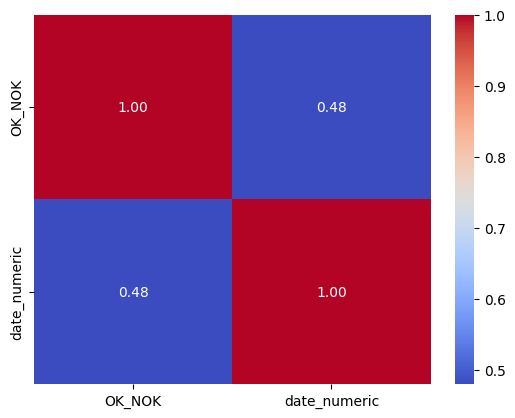

In [180]:
g = sns.heatmap(modified_df[["OK_NOK", "date_numeric"]].corr(), annot=True, fmt=".2f", cmap="coolwarm")

**Comment** While the linear correlation between the 'date_numeric' feature and 'OK_NOK' suggests improvements in supplier quality over time and reflects the success of the quality department, it also raises concerns about potential data leakage. This inadvertently includes information not available during prediction, compromising model integrity. To address this, we should exclude features like 'date_numeric' from training set to ensure predictions rely solely on relevant, future-available data.

In [181]:
modified_df.to_csv('to_modeling_dataframe.csv', index=False)
dtype = {'date_fmt': 'datetime64[ns]'}
to_modeling_df = pd.read_csv('to_modeling_dataframe.csv', parse_dates=['date_fmt'])


**Comment** balance df. You make a valid point. Randomly removing samples from the majority class can indeed lead to loss of information, especially if the majority class contains valuable data points that are important for making accurate predictions. In scenarios like quality control of shipments, where the class distribution naturally tends to be imbalanced, blindly undersampling the majority class may not be the best approach.

Instead of randomly removing samples from the majority class, you might consider using more sophisticated techniques that preserve the information in the dataset while balancing the class distribution

    SMOTE (Synthetic Minority Over-sampling Technique): This technique generates synthetic samples for the minority class to balance the class distribution while avoiding loss of information.

    Borderline-SMOTE: Similar to SMOTE, but it focuses on generating synthetic samples near the decision boundary, which can lead to better generalization.

    ADASYN (Adaptive Synthetic Sampling): It adaptively generates synthetic samples for the minority class based on the local density of minority and majority samples.

    Class weights: Many classifiers in scikit-learn allow you to assign different weights to different classes. By assigning higher weights to the minority class, you can effectively mitigate the impact of class imbalance during training.

    Ensemble methods: Algorithms like BalancedRandomForestClassifier and EasyEnsembleClassifier in imbalanced-learn can train multiple classifiers on balanced subsets of the data and combine their predictions to improve performance.e:

In [182]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

target = to_modeling_df['OK_NOK']
features = to_modeling_df.drop(['date_fmt','OK_NOK','date_numeric'], axis=1)


# Define the under-sampling and over-sampling techniques
over_sampler = SMOTE(sampling_strategy='not majority')

# Create a pipeline to combine under-sampling and over-sampling
sampling_pipeline = Pipeline([
    ('over_sampling', over_sampler)
])



# Fit and transform the data using the sampling pipeline
X_resampled, y_resampled = sampling_pipeline.fit_resample(features, target)


In [183]:
resampled_df = pd.concat([y_resampled, X_resampled], axis = 1)

In [184]:
resampled_df

,OK_NOK,pcs_pack,delivered_pcs_pack,pack_weight_kg,"QUANTITY_(-0.001, 0.2]","QUANTITY_(0.2, 0.4]","QUANTITY_(0.4, 0.6]","QUANTITY_(0.6, 0.8]","QUANTITY_(0.8, 1.0]",LEN_4.05,...,surface_finish_color1,surface_finish_color2,surface_finish_color3,supplier_SU0,supplier_SU1,supplier_SU2,supplier_SU3,supplier_SU4,supplier_SU5,supplier_SU6
0,0,0.60,50.00,0.35,False,False,True,False,False,True,...,False,True,False,True,False,False,False,False,False,False
1,0,0.60,40.00,0.75,False,True,False,False,False,False,...,False,True,False,True,False,False,False,False,False,False
2,0,0.60,50.00,0.35,False,False,True,False,False,True,...,False,True,False,True,False,False,False,False,False,False
3,0,0.60,50.00,0.35,False,False,True,False,False,True,...,False,True,False,True,False,False,False,False,False,False
4,0,0.60,40.00,0.22,False,True,False,False,False,False,...,False,True,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9089,0,0.60,40.00,0.75,False,True,False,False,False,False,...,False,True,False,True,False,False,False,False,False,False
9090,0,0.30,20.00,0.54,True,False,False,False,False,False,...,False,True,False,True,False,False,False,False,False,False
9091,0,0.30,20.00,0.61,True,False,False,False,False,False,...,False,True,False,True,False,False,False,False,False,False
9092,0,0.60,50.00,0.42,False,False,True,False,False,True,...,False,True,False,False,True,False,False,False,False,False


In [185]:
resampled_ok_nok_vc = resampled_df['OK_NOK'].value_counts()
print(resampled_ok_nok_vc)

total_samples = resampled_ok_nok_vc.sum()
percentage_0 = (resampled_ok_nok_vc[0] / total_samples) * 100
percentage_1 = (resampled_ok_nok_vc[1] / total_samples) * 100

print(f"Percentage of class 0: {percentage_0:.2f}%")
print(f"Percentage of class 1: {percentage_1:.2f}%")


OK_NOK
0    4547
1    4547
Name: count, dtype: int64
Percentage of class 0: 50.00%
Percentage of class 1: 50.00%


**Spliting dataset**

### 6.1 Simple modeling
#### Cross validate models

I used 11 popular classifiers and evaluated their mean: accuracy, precision, recall, false positive rate, and Receiver Operating Characteristic (ROC) Area Under the Curve (AUC) of each of them by a stratified k-fold cross-validation procedure.

* SVC
* Decision Tree Classifier 
* AdaBoost 
* Random Forest
* Extra Trees
* Gradient Boosting
* Multiple layer perceptron (neural network)
* KNN
* Logistic regression
* Linear Discriminant Analysis
* Catboost


In [186]:
# Cross validate model with Kfold stratified cross val
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=5, shuffle=True)
random_state = 54

Cross validation on features and label with new metric called: 
True Negative Rate=True Negatives/True Negatives​ + False Negatives

In [187]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from catboost import CatBoostClassifier

from sklearn.model_selection import cross_validate

# Define the classifiers and scoring metrics
classifiers = [
    SVC(random_state=random_state),
    DecisionTreeClassifier(random_state=random_state),
    AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state), random_state=random_state),
    RandomForestClassifier(random_state=random_state),
    ExtraTreesClassifier(random_state=random_state),
    GradientBoostingClassifier(random_state=random_state),
    MLPClassifier(random_state=random_state),
    KNeighborsClassifier(),
    LogisticRegression(random_state=random_state),
    LinearDiscriminantAnalysis(),
    CatBoostClassifier(random_state=random_state)
]

from sklearn.metrics import make_scorer

def new_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    negative_precison = tn / (tn + fn)
    f1_negative = 2 * (specificity*negative_precison) / (specificity + negative_precison)
    return specificity, negative_precison, f1_negative

# Create a scorer for specificity using make_scorer
specificity_scorer = make_scorer(lambda y_true, y_pred: new_score(y_true, y_pred)[0], greater_is_better=True)

# Create a scorer for negative precision using make_scorer
negative_precision_scorer = make_scorer(lambda y_true, y_pred: new_score(y_true, y_pred)[1], greater_is_better=True)

# Create a scorer for negative precision using make_scorer
f1_negative_scorer = make_scorer(lambda y_true, y_pred: new_score(y_true, y_pred)[2], greater_is_better=True)

# Add specificity to your scoring metrics dictionary
scoring_metrics = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'specificity': specificity_scorer,
    'negative_precison' : negative_precision_scorer,
    'f1_negative': f1_negative_scorer
}


# List to hold cross-validation results for each classifier
# cv_results = []
cv_results_resampled = []

# Perform cross-validation for each classifier
# for classifier in classifiers:
#     cv_result = cross_validate(classifier, X_train, y=y_train, scoring=scoring_metrics, cv=kfold, n_jobs=12)
#     cv_results.append(cv_result)

for classifier in classifiers:
    cv_result_resampled = cross_validate(classifier, X_resampled, y=y_resampled, scoring=scoring_metrics, cv=kfold, n_jobs=-1)
    cv_results_resampled.append(cv_result_resampled)

In [199]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

# Define the number of folds
kfold = StratifiedKFold(n_splits=5, shuffle=True)

# Initialize a list to store all fold indices
all_fold_indices = []

# Iterate over each fold
for fold_idx, (train_indices, test_indices) in enumerate(kfold.split(X_resampled, y_resampled)):
    fold_indices = {'Fold': fold_idx + 1, 'Train Indices': train_indices, 'Test Indices': test_indices}
    all_fold_indices.append(fold_indices)

# Convert the list to a DataFrame
fold_indices_df = pd.DataFrame(all_fold_indices)

# Print the DataFrame
print(fold_indices_df)



   Fold                                      Train Indices  \
0     1  [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 14, 15...   
1     2  [0, 1, 2, 3, 4, 7, 8, 9, 10, 11, 12, 13, 14, 1...   
2     3  [0, 1, 2, 5, 6, 7, 8, 9, 11, 12, 14, 15, 17, 1...   
3     4  [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 16, 17...   
4     5  [2, 3, 4, 5, 6, 8, 10, 11, 12, 13, 14, 15, 16,...   

                                        Test Indices  
0  [8, 11, 17, 26, 30, 33, 39, 41, 42, 50, 51, 52...  
1  [5, 6, 18, 24, 27, 34, 35, 45, 54, 61, 64, 71,...  
2  [3, 4, 10, 13, 16, 20, 25, 32, 40, 43, 47, 48,...  
3  [2, 12, 14, 15, 28, 29, 31, 36, 37, 44, 49, 55...  
4  [0, 1, 7, 9, 19, 21, 22, 23, 38, 46, 74, 77, 8...  


In [195]:
# Create a dictionary to hold the data
algorithms =["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis", "CatBoost"]

data_resampled = {}
data_std_resampled = {}

# Iterate over the algorithms and their corresponding results
for algorithm, result in zip(algorithms, cv_results_resampled):
    # Create a dictionary to hold the results for the current algorithm
    algorithm_results = {}
    algorithm_std = {}
    # Iterate over the metrics and their scores
    for metric, scores in result.items():
        # Add the metric and its mean score to the algorithm_results dictionary
        algorithm_results[metric] = scores.mean()
        algorithm_std[metric] = scores.std()
    # Add the algorithm and its results to the data dictionary
    data_resampled[algorithm] = algorithm_results
    data_std_resampled[algorithm] = algorithm_std

# Convert the data dictionary into a DataFrame
cv_res_df_resampled = pd.DataFrame(data_resampled).T
cv_std_df_resampled = pd.DataFrame(data_std_resampled).T

### Evaluating train set results

n the context of predicting NOK products (class 0), we're indeed interested not only in how many times we predicted 0 and were wrong (false positives) but also in how many times we predicted 1 (OK products) and were wrong (false negatives).

In this scenario, the metric that measures the model's ability to correctly identify both classes is specificity, also known as the true negative rate. Specificity is calculated as:

Specificity=True NegativesTrue Negatives+False PositivesSpecificity=True Negatives+False PositivesTrue Negatives​

It measures the proportion of actual NOK (class 0) instances that were correctly identified by the model among all actual NOK instances.

In your example:

    True Negatives (correctly predicted NOK samples) = 1
    False Positives (incorrectly predicted OK samples as NOK) = 0

Specificity = 1 / (1 + 0) = 1.0

So, in this example, the specificity would be 1.0, indicating that our model correctly identified 100% of all actual NOK (class 0) samples. This means that out of all the NOK samples, our model rarely misclassified them as OK.

Therefore, specificity complements recall by providing information about the model's performance in correctly identifying the negative class. Both metrics together offer a more comprehensive understanding of the model's performance across different classes.ation.oducts).

In [196]:
# cv_res_df.sort_values(by='test_specificity', ascending=False)

In [197]:
# cv_std_df

In [198]:
cv_res_df_resampled.sort_values(by='test_f1_negative', ascending=False)

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc,test_specificity,test_negative_precison,test_f1_negative
ExtraTrees,5.17,0.14,0.84,0.90,0.76,0.82,0.90,0.92,0.79,0.85
RandomForest,3.86,0.16,0.84,0.89,0.77,0.82,0.90,0.91,0.80,0.85
DecisionTree,0.26,0.05,0.83,0.90,0.74,0.81,0.89,0.92,0.78,0.84
AdaBoost,3.67,0.27,0.83,0.88,0.76,0.82,0.89,0.90,0.79,0.84
CatBoost,12.02,0.93,0.83,0.86,0.78,0.82,0.90,0.88,0.80,0.83
MultipleLayerPerceptron,20.05,0.06,0.82,0.86,0.77,0.81,0.90,0.87,0.79,0.83
KNeighboors,0.08,0.90,0.80,0.81,0.77,0.79,0.85,0.82,0.78,0.80
LinearDiscriminantAnalysis,0.84,0.05,0.77,0.77,0.78,0.77,0.85,0.77,0.77,0.77
GradientBoosting,3.93,0.06,0.77,0.75,0.81,0.78,0.85,0.73,0.79,0.76
LogisticRegression,1.12,0.07,0.75,0.75,0.74,0.75,0.82,0.75,0.75,0.75



  True Positive Rate (Recall t. TPR or Recall measures the proportion of actual positive instances (class 1) that are correctly classified by the model. In your example, the TPR is indeed 80%, indicating that the model correctly identified 80% of the positive instances
    Preci rect. Precision focuses on the proportion of correctly predicted positive instances among all instances predicted as positive. In your example, the precision is calculated as 4664​, indicating that 4 out of 6 positive predictions are corr

    F1 Score: TCorrect. The F1 score is the harmonic mean of precision and recall, providing a balanced measure of a model's performance. It considers both false positives and false negatives and is useful when the classes are imbced.

    True Negative Rate (S     Correct. TNR or Specificity measures the proportion of actual negative instances (class 0) that are correctly classified by the model. In your example, the TNR is indeed 60%, indicating that the model correctly identified 60% of the negativetances.

    Nega        Correct. Negative Precision considers the proportion of correctly predicted negative instances among all instances predicted as negative. It is analogous to precision but focuses on the nive class.

     
        Correct. F1 Negative Score is similar to the F1 score but focuses on the negative class. It provides a balanced measure of a model's performance in predicting tscenarios. Well done!

In [ ]:
# cv_std_df_resampled

In [ ]:
# fit_time_mean = cv_res_df.groupby(cv_res_df.index)['fit_time'].mean()
# fit_time_order = fit_time_mean.sort_values().index

In [ ]:
# score_time_mean = cv_res_df.groupby(cv_res_df.index)['score_time'].mean()
# score_time_order = score_time_mean.sort_values().index

In [ ]:
# test_accuracy_mean = cv_res_df.groupby(cv_res_df.index)['test_accuracy'].mean()
# test_accuracy_order = test_accuracy_mean.sort_values(ascending=False).index

In [ ]:
# prec_mean = cv_res_df.groupby(cv_res_df.index)['test_precision'].mean()
# prec_order = prec_mean.sort_values(ascending=False).index

In [ ]:
# rec_mean = cv_res_df.groupby(cv_res_df.index)['test_recall'].mean()
# rec_order = rec_mean.sort_values(ascending=False).index

In [ ]:
# f1_mean = cv_res_df.groupby(cv_res_df.index)['test_f1'].mean()
# f1_order = f1_mean.sort_values(ascending=False).index

In [ ]:
# roc_mean = cv_res_df.groupby(cv_res_df.index)['test_roc_auc'].mean()
# roc_order = roc_mean.sort_values(ascending=False).index

In [ ]:
# import matplotlib.pyplot as plt

# orders = [fit_time_order, score_time_order, test_accuracy_order, prec_order, rec_order, f1_order, roc_order]

# # Define the number of rows and columns
# num_metrics = len(orders)
# num_rows = num_metrics
# num_cols = 1

# # Create subplots
# fig, ax = plt.subplots(num_rows, num_cols, figsize=(8, 6*num_metrics))

# # Iterate over each metric
# for i, metric in enumerate(cv_res_df.columns):
#     # Plot the bar plot on the respective subplot
#     sns.barplot(x=cv_res_df[metric], y=cv_res_df.index, data=cv_res_df, palette="Set2", orient="h", order=orders[i], ax=ax[i])
#     x_error_left = cv_res_df[metric] - cv_std_df[metric] / 2
#     x_error_right = cv_res_df[metric] + cv_std_df[metric] / 2
    
#     # Add error bars
#     ax[i].errorbar(x=cv_res_df[metric], y=cv_res_df.index, xerr=[cv_res_df[metric] - x_error_left, x_error_right - cv_res_df[metric]], fmt='none', c='black')
    
#     ax[i].set_title(metric)
    

# plt.tight_layout()
# plt.show()


### Hyperparameter tuning for best models podział train test split.

In [277]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.2, random_state = 54, stratify=y_resampled)

In [207]:
from sklearn.model_selection import GridSearchCV

# ExtraTrees

# Define the parameter grid
extra_trees_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize ExtraTreesClassifier
extra_trees = ExtraTreesClassifier(random_state=random_state)

# Initialize GridSearchCV
extra_trees_grid_search = GridSearchCV(extra_trees, extra_trees_param_grid, cv=kfold, scoring='precision', n_jobs=-1, verbose=1)

# Perform grid search
extra_trees_grid_search.fit(X_train, y_train)

# Get the best hyperparameters
extra_trees_best_params = extra_trees_grid_search.best_params_
extra_trees_precision = extra_trees_grid_search.best_score_
extra_trees_best_model = extra_trees_grid_search.best_estimator_

Fitting 5 folds for each of 135 candidates, totalling 675 fits


In [208]:
extra_trees_best_params

{'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [209]:
extra_trees_precision

0.8967280347208518

In [210]:
# DecisionTree
# Define the parameter grid
decision_tree_param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize DecisionTreeClassifier
decision_tree = DecisionTreeClassifier(random_state=random_state)

# Initialize GridSearchCV
decision_tree_grid_search = GridSearchCV(decision_tree, decision_tree_param_grid, cv=kfold, scoring='precision', n_jobs=-1, verbose=1)

# Perform grid search
decision_tree_grid_search.fit(X_train, y_train)

# Get the best hyperparameters
decision_tree_best_params = decision_tree_grid_search.best_params_
decision_tree_precision = decision_tree_grid_search.best_score_
decision_tree_best_model = decision_tree_grid_search.best_estimator_

Fitting 5 folds for each of 45 candidates, totalling 225 fits


In [211]:
decision_tree_precision

0.9021534838261758

In [212]:
#  Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the GradientBoostingClassifier
random_forest = RandomForestClassifier(random_state=54)

# Create the GridSearchCV object
gs_random_forest = GridSearchCV(random_forest, param_grid=rf_param_grid, cv=kfold, scoring='precision', n_jobs=-1, verbose=1)

# Perform the grid search
gs_random_forest.fit(X_train, y_train)

# Get the best parameters and the best score
gs_random_forest_best_params = gs_random_forest.best_params_
gs_random_forest_precision = gs_random_forest.best_score_
rf_best_model = gs_random_forest.best_estimator_


Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [213]:
gs_random_forest_precision

0.8955280150824871

In [214]:
# CatBoost
catboost_param_grid = {
    'iterations': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [3, 5, 7]
}

# Initialize CatBoost classifier
catboost = CatBoostClassifier()

# Initialize GridSearchCV
catboost_grid_search = GridSearchCV(catboost, catboost_param_grid, cv=kfold, scoring='precision', n_jobs=-1, verbose=1)

# Perform grid search
catboost_grid_search.fit(X_train, y_train)

# Get the best hyperparameters
catboost_best_params = catboost_grid_search.best_params_
catboost_best_precision = catboost_grid_search.best_score_
catboost_best_model = catboost_grid_search.best_estimator_


Fitting 5 folds for each of 27 candidates, totalling 135 fits
0:	learn: 0.6410496	total: 7.26ms	remaining: 1.44s
1:	learn: 0.6158658	total: 14ms	remaining: 1.39s
2:	learn: 0.5828447	total: 20.3ms	remaining: 1.33s
3:	learn: 0.5667337	total: 26.3ms	remaining: 1.29s
4:	learn: 0.5555595	total: 32.4ms	remaining: 1.26s
5:	learn: 0.5464898	total: 38ms	remaining: 1.23s
6:	learn: 0.5355860	total: 43.6ms	remaining: 1.2s
7:	learn: 0.5318177	total: 49.5ms	remaining: 1.19s
8:	learn: 0.5255471	total: 55.1ms	remaining: 1.17s
9:	learn: 0.5219881	total: 60.6ms	remaining: 1.15s
10:	learn: 0.5149953	total: 66.2ms	remaining: 1.14s
11:	learn: 0.5125266	total: 71.6ms	remaining: 1.12s
12:	learn: 0.5090605	total: 77.5ms	remaining: 1.11s
13:	learn: 0.5064999	total: 83.2ms	remaining: 1.1s
14:	learn: 0.5004966	total: 88.7ms	remaining: 1.09s
15:	learn: 0.4987784	total: 94.5ms	remaining: 1.09s
16:	learn: 0.4923868	total: 100ms	remaining: 1.08s
17:	learn: 0.4899082	total: 106ms	remaining: 1.07s
18:	learn: 0.4883609

In [215]:
print(catboost_best_params)
catboost_best_precision


{'depth': 7, 'iterations': 200, 'learning_rate': 0.2}


0.8867040994831459

In [ ]:
# # Gradient Boosting
# gb_param_grid = {
#     'n_estimators': [50, 100, 200],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_depth': [3, 5, 7]
# }

# # Create the GradientBoostingClassifier
# gb_clf = GradientBoostingClassifier(random_state=42)

# # Create the GridSearchCV object
# gs_gb_clf = GridSearchCV(estimator=gb_clf, param_grid=gb_param_grid, cv=kfold, scoring=f1_negative_scorer, n_jobs=-1, verbose=1)

# # Perform the grid search
# gs_gb_clf.fit(X_train, y_train)

# # Get the best parameters and the best score
# gb_best_params = gs_gb_clf.best_params_
# gb_best_score = gs_gb_clf.best_score_
# gb_best_model = gs_gb_clf.best_estimator_


In [ ]:
# print(gb_best_params)
# gb_best_score

In [ ]:
# # Adaboost
# DTC = DecisionTreeClassifier()

# adaDTC = AdaBoostClassifier(DTC, random_state=7)

# ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
#               "base_estimator__splitter" :   ["best", "random"],
#               "algorithm" : ["SAMME","SAMME.R"],
#               "n_estimators" :[1,2],
#               "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

# gs_ada_DTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring=f1_negative_scorer, n_jobs= 12, verbose = 1)

# gs_ada_DTC.fit(X_train, y_train)

# gs_ada_DTC_best_params = gs_ada_DTC.best_params_
# gs_ada_DTC_best_score = gs_ada_DTC.best_score_
# ada_best_model = gs_ada_DTC.best_estimator_


In [ ]:
# print(gs_ada_DTC_best_params)
# gs_ada_DTC_best_score

In [216]:

# Define the parameter grid
logistic_regression_param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [50, 100, 200, 500]
}

# Initialize Logistic Regression classifier
logistic_regression = LogisticRegression(random_state=random_state)

# Initialize GridSearchCV
logistic_regression_grid_search = GridSearchCV(logistic_regression, logistic_regression_param_grid, cv=kfold, scoring='precision', n_jobs=-1, verbose=1)

# Perform grid search
logistic_regression_grid_search.fit(X_train, y_train)

# Get the best hyperparameters
logistic_regression_best_params = logistic_regression_grid_search.best_params_
logistic_regression_precision = logistic_regression_grid_search.best_score_
logistic_regression_best_model = logistic_regression_grid_search.best_estimator_


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


In [217]:
logistic_regression_precision

0.7774068420699418

### Plot learning curves

Learning curves are a good way to see the overfitting effect on the training set and the effect of the training size on the accuracy.

In [223]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='precision')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt
    

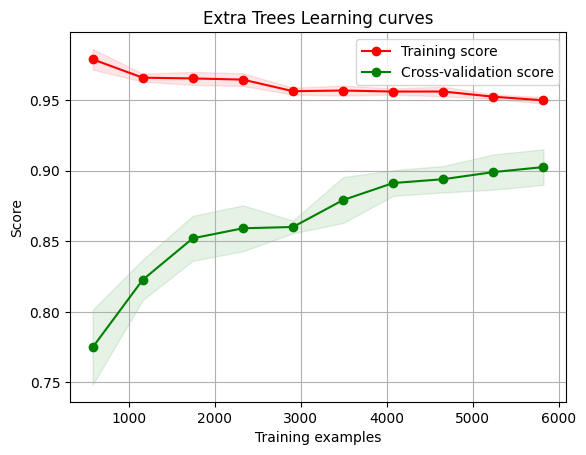

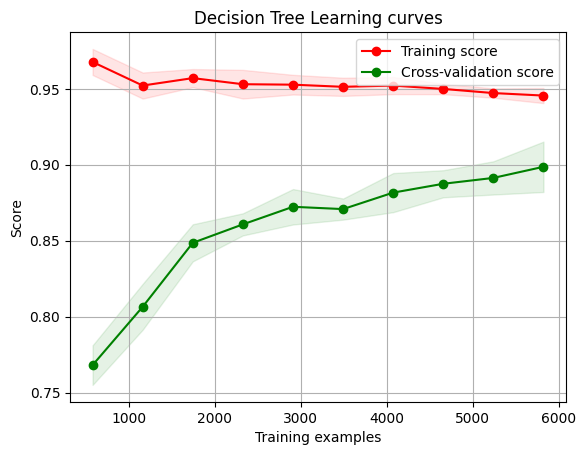

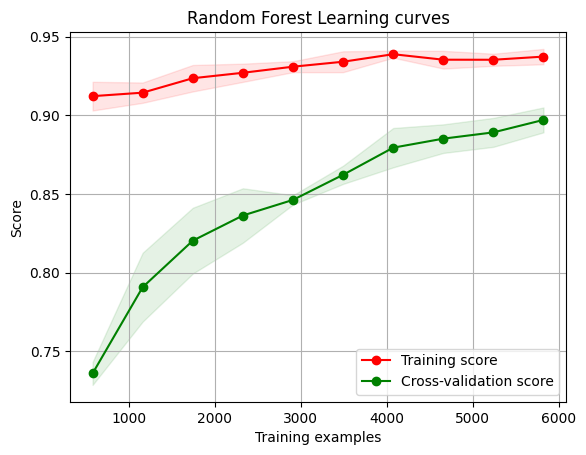

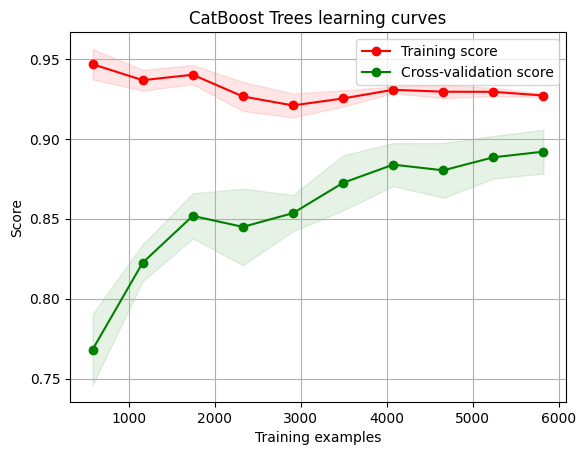

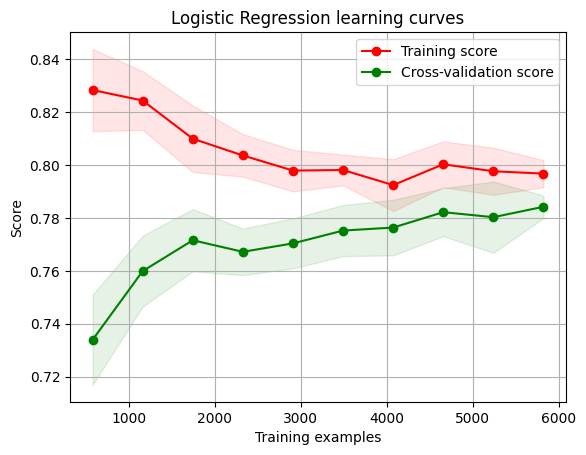

In [224]:
plot_learning_curve(extra_trees_best_model,"Extra Trees Learning curves",X_train,y_train,cv=kfold)
plot_learning_curve(decision_tree_best_model,"Decision Tree Learning curves",X_train,y_train,cv=kfold)
plot_learning_curve(rf_best_model,"Random Forest Learning curves",X_train,y_train,cv=kfold)
plot_learning_curve(catboost_best_model,"CatBoost Trees learning curves",X_train,y_train,cv=kfold)
# plot_learning_curve(gb_best_model,"Gradient Boosting Learning curves",X_train,y_train,cv=kfold)
# plot_learning_curve(ada_best_model,"AdaBoost Trees learning curves",X_train,y_train,cv=kfold)
plot_learning_curve(logistic_regression_best_model,"Logistic Regression learning curves",X_train,y_train,cv=kfold)

# ada_best_model = gs_ada_DTC.best_estimator_
# rf_best_model = gs_random_forest.best_estimator_
# gb_best_model = gs_gb_clf.best_estimator_
# catboost_best_model = catboost_grid_search.best_estimator_
# knn_best_model

plt.show()

### Feature importance of the tree-based classifiers

In order to see the most informative features for the prediction of incoming goods, I displayed the feature importance for the 4 tree based classifiers.

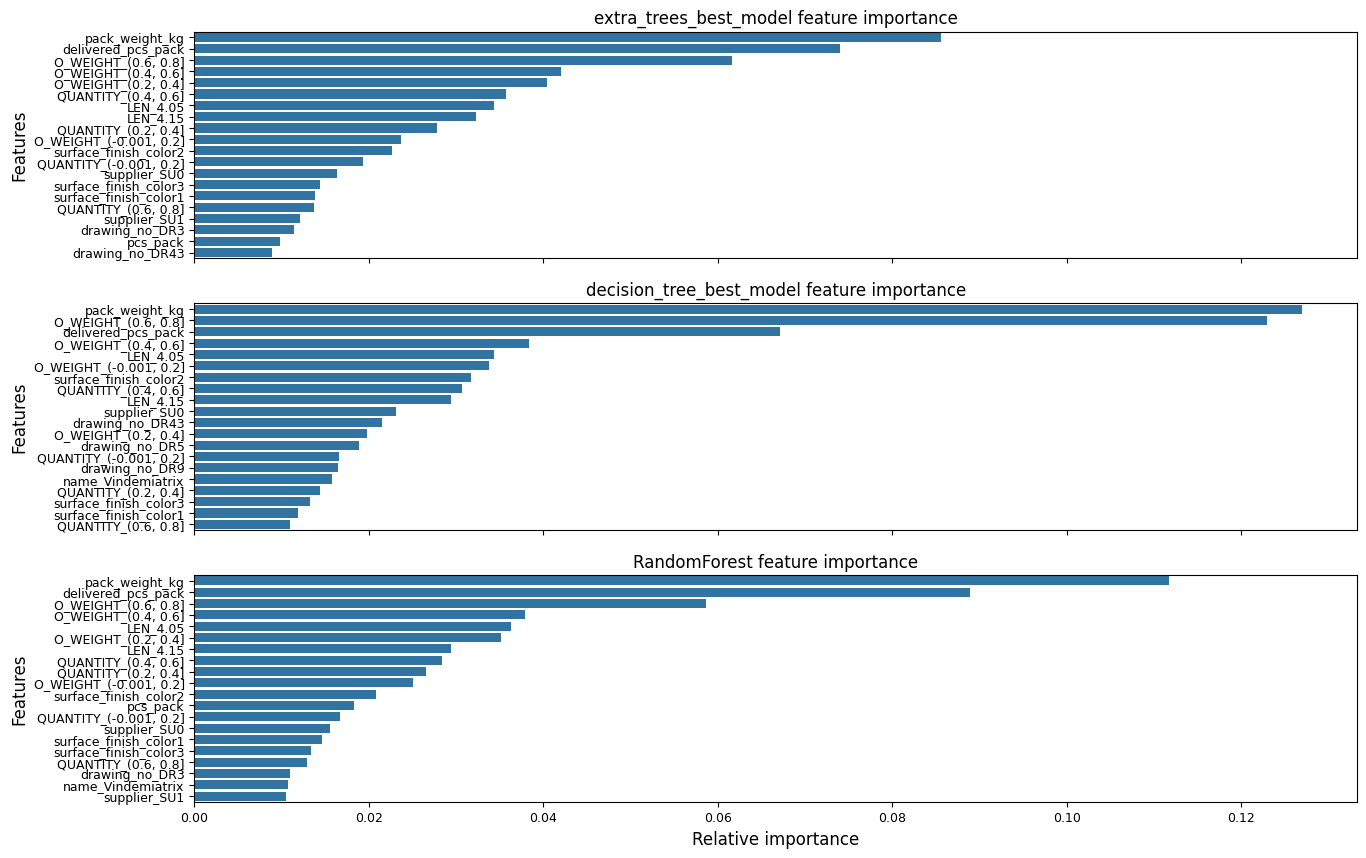

In [228]:
nrows = 3
ncols = 1
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,10))

names_classifiers = [('extra_trees_best_model', extra_trees_best_model),('decision_tree_best_model', decision_tree_best_model),('RandomForest', rf_best_model)]

nclassifier = 0
for row in range(nrows):
    name = names_classifiers[nclassifier][0]
    classifier = names_classifiers[nclassifier][1]
    indices = np.argsort(classifier.feature_importances_)[::-1][:20]
    
    g = sns.barplot(y=X_train.columns[indices][:20],x = classifier.feature_importances_[indices][:20] , orient='h',ax=axes[row])
    g.set_xlabel("Relative importance",fontsize=12)
    g.set_ylabel("Features",fontsize=12)
    g.tick_params(labelsize=9)
    g.set_title(name + " feature importance")
    nclassifier += 1

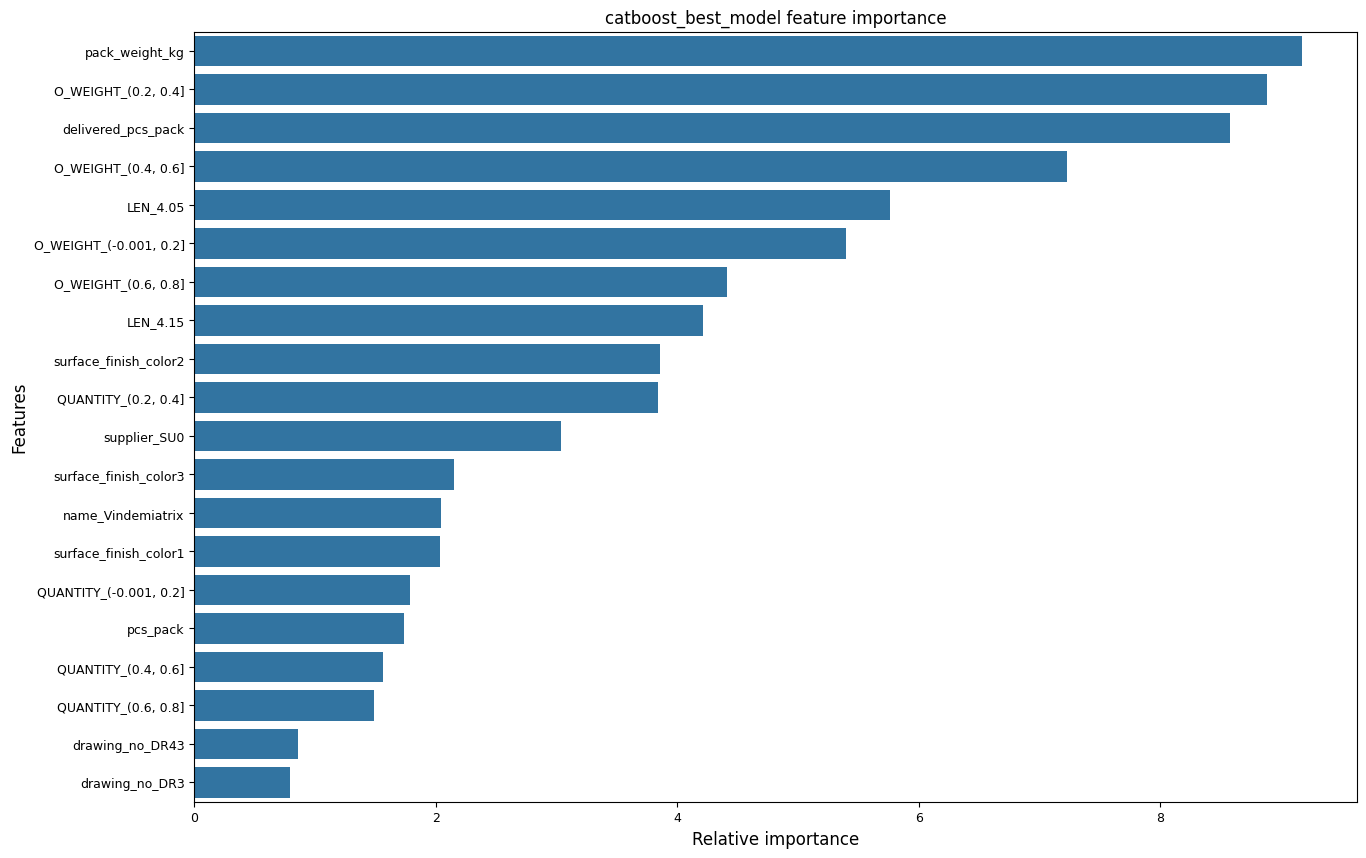

In [229]:
nrows = 1
ncols = 1
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,10))

names_classifiers = [('catboost_best_model', catboost_best_model)]

nclassifier = 0


name = names_classifiers[nclassifier][0]
classifier = names_classifiers[nclassifier][1]
indices = np.argsort(classifier.feature_importances_)[::-1][:20]

g = sns.barplot(y=X_train.columns[indices][:20],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes)
g.set_xlabel("Relative importance",fontsize=12)
g.set_ylabel("Features",fontsize=12)
g.tick_params(labelsize=9)
g.set_title(name + " feature importance")
nclassifier += 1

**Comment** Now let's see the performance of those models on unseen data

Add feature selection to compare with feature_importance_ from trees

### Using chosen models with test set

In [292]:
et_pred = extra_trees_best_model.predict(X_test)


et_accuracy = accuracy_score(y_test, et_pred)

et_precision = precision_score(y_test, et_pred, pos_label=1)
et_recall = recall_score(y_test, et_pred, pos_label=1)
et_f1 = f1_score(y_test, et_pred, pos_label=1)

et_precision_neg = precision_score(y_test, et_pred, pos_label=0)
et_f1_neg = f1_score(y_test, et_pred, pos_label=0)

et_roc_auc = roc_auc_score(y_test, et_pred)

# Calculate specificity
tn, fp, _, _ = confusion_matrix(y_test, et_pred).ravel()
et_specificity = tn / (tn + fp)

# Create DataFrame
results_data = {
    'Accuracy': et_accuracy,
    'Precision': et_precision,
    'Recall': et_recall,
    'F1 Score': et_f1,
    'ROC AUC': et_precision_neg,
    'Specificity': specificity,
    'Negative Precision': et_precision_neg,
    'Negative F1 Score': et_f1_neg,
}
et_df = pd.DataFrame(results_data, index=['Extra Trees'])

et_df

,Accuracy,Precision,Recall,F1 Score,ROC AUC,Specificity,Negative Precision,Negative F1 Score
Extra Trees,0.83,0.89,0.76,0.82,0.79,0.90,0.79,0.85


In [295]:

dt_pred = decision_tree_best_model.predict(X_test)

dt_accuracy = accuracy_score(y_test, dt_pred)

dt_precision = precision_score(y_test, dt_pred, pos_label=1)
dt_recall = recall_score(y_test, dt_pred, pos_label=1)
dt_f1 = f1_score(y_test, dt_pred, pos_label=1)

dt_precision_neg = precision_score(y_test, dt_pred, pos_label=0)
dt_f1_neg = f1_score(y_test, dt_pred, pos_label=0)
roc_auc = roc_auc_score(y_test, dt_pred)

# Calculate specificity
tn, fp, _, _ = confusion_matrix(y_test, dt_pred).ravel()
specificity = tn / (tn + fp)

# Create DataFrame
results_data = {
    'Accuracy': dt_accuracy,
    'Precision': dt_precision,
    'Recall': dt_recall,
    'F1 Score': dt_f1,
    'ROC AUC': roc_auc,
    'Specificity': specificity,
    'Negative Precision': dt_precision_neg,
    'Negative F1 Score': dt_f1_neg,
}
dt_df = pd.DataFrame(results_data, index=['Decision Tree'])

dt_df

,Accuracy,Precision,Recall,F1 Score,ROC AUC,Specificity,Negative Precision,Negative F1 Score
Decision Tree,0.82,0.88,0.75,0.81,0.82,0.90,0.78,0.84


In [264]:
cv_res_df_resampled.sort_values(by='test_f1_negative', ascending=False)

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc,test_specificity,test_negative_precison,test_f1_negative
ExtraTrees,5.17,0.14,0.84,0.90,0.76,0.82,0.90,0.92,0.79,0.85
RandomForest,3.86,0.16,0.84,0.89,0.77,0.82,0.90,0.91,0.80,0.85
DecisionTree,0.26,0.05,0.83,0.90,0.74,0.81,0.89,0.92,0.78,0.84
AdaBoost,3.67,0.27,0.83,0.88,0.76,0.82,0.89,0.90,0.79,0.84
CatBoost,12.02,0.93,0.83,0.86,0.78,0.82,0.90,0.88,0.80,0.83
MultipleLayerPerceptron,20.05,0.06,0.82,0.86,0.77,0.81,0.90,0.87,0.79,0.83
KNeighboors,0.08,0.90,0.80,0.81,0.77,0.79,0.85,0.82,0.78,0.80
LinearDiscriminantAnalysis,0.84,0.05,0.77,0.77,0.78,0.77,0.85,0.77,0.77,0.77
GradientBoosting,3.93,0.06,0.77,0.75,0.81,0.78,0.85,0.73,0.79,0.76
LogisticRegression,1.12,0.07,0.75,0.75,0.74,0.75,0.82,0.75,0.75,0.75


### Evaluating test set results??

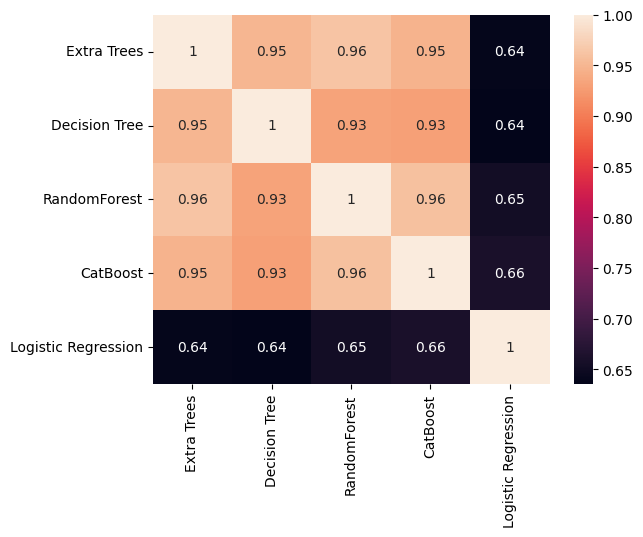

In [220]:
test_IG_ET = pd.Series(extra_trees_best_model.predict(X_test), name='Extra Trees')
test_IG_DT = pd.Series(decision_tree_best_model.predict(X_test), name='Decision Tree')
test_IG_RF = pd.Series(rf_best_model.predict(X_test), name='RandomForest')
test_IG_CB = pd.Series(catboost_best_model.predict(X_test), name='CatBoost')
test_IG_LR = pd.Series(logistic_regression_best_model.predict(X_test), name='Logistic Regression')

# Concatenate all classifier results
ensemble_results = pd.concat([test_IG_ET,test_IG_DT, test_IG_RF,test_IG_CB,test_IG_LR],axis=1)

g= sns.heatmap(ensemble_results.corr(),annot=True)

**Comment** The 5 classifiers give more or less the same prediction but there is some differences. Theses differences between the 5 classifier predictions are sufficient to consider an ensembling vote.

### 6.2 Ensemble modelings

In [243]:
test_IG_ET = pd.Series(extra_trees_best_model.predict(X_test), name='Extra Trees')
test_IG_DT = pd.Series(decision_tree_best_model.predict(X_test), name='Decision Tree')
test_IG_RF = pd.Series(rf_best_model.predict(X_test), name='RandomForest')
test_IG_CB = pd.Series(catboost_best_model.predict(X_test), name='CatBoost')
test_IG_LR = pd.Series(logistic_regression_best_model.predict(X_test), name='Logistic Regression')

from sklearn.ensemble import VotingClassifier

votingC = VotingClassifier(estimators=[
    ('Extra Trees', extra_trees_best_model), ('Decision Tree', decision_tree_best_model),('RandomForest', rf_best_model),('CatBoost', catboost_best_model),('Logistic Regression',logistic_regression_best_model)], voting='soft', n_jobs=-1)

votingC = votingC.fit(X_train, y_train)


In [296]:
vc_y_pred = votingC.predict(X_test)

vc_accuracy = accuracy_score(y_test, vc_y_pred)

vc_precision = precision_score(y_test, vc_y_pred, pos_label=1)
vc_recall = recall_score(y_test, vc_y_pred, pos_label=1)
vc_f1 = f1_score(y_test, vc_y_pred, pos_label=1)

vc_precision_neg = precision_score(y_test, vc_y_pred, pos_label=0)
vc_f1_neg = f1_score(y_test, vc_y_pred, pos_label=0)
vc_roc_auc = roc_auc_score(y_test, vc_y_pred)

# Calculate specificity
tn, fp, _, _ = confusion_matrix(y_test, vc_y_pred).ravel()
vc_specificity = tn / (tn + fp)

# Create DataFrame
results_data = {
    'Accuracy': vc_accuracy,
    'Precision': vc_precision,
    'Recall': vc_recall,
    'F1 Score': vc_f1,
    'ROC AUC': vc_roc_auc,
    'Specificity': vc_specificity,
    'Negative Precision': vc_precision_neg,
    'Negative F1 Score': vc_f1_neg,
}
vatingC_df = pd.DataFrame(results_data, index=['VotingC'])

vatingC_df

,Accuracy,Precision,Recall,F1 Score,ROC AUC,Specificity,Negative Precision,Negative F1 Score
VotingC,0.84,0.90,0.78,0.83,0.84,0.91,0.80,0.85


In [298]:
final_df = pd.concat([et_df, dt_df, vatingC_df], axis=0)
final_df

,Accuracy,Precision,Recall,F1 Score,ROC AUC,Specificity,Negative Precision,Negative F1 Score
Extra Trees,0.83,0.89,0.76,0.82,0.79,0.90,0.79,0.85
Decision Tree,0.82,0.88,0.75,0.81,0.82,0.90,0.78,0.84
VotingC,0.84,0.90,0.78,0.83,0.84,0.91,0.80,0.85


### 6.3 Prediction

Transformations to columns:
  
    * pcs_pck - log transformation and MinMax: pcs_pck_scaler
    * pcs_length_mm - bins
    * overall_weight_kg - log transformation
    * quantity_pcs - bins
    * pack_weight_kg - log transformation and MinMax: pack_weight_scaler
    * delivered_pcs_pack - dropped

In [305]:
from sklearn.metrics import precision_score, recall_score, f1_score

vc_y_proba = votingC.predict_proba(X_test)

# Assuming y_pred_rf contains probabilities for the positive class
positive_class_proba = vc_y_proba[:, 1]  # Assuming the positive class is the first class

# Define a range of thresholds to experiment with
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]  # Example thresholds, you can adjust as needed

# Initialize a dictionary to store results
threshold_results = {}
threshold_results_recall = {}

# Loop over each threshold
for threshold in thresholds:
    # Convert probabilities to binary predictions based on the threshold
    y_pred = (positive_class_proba >= threshold).astype(int)
    
    # Calculate precision for the positive class predictions
    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    
    # Store the precision for this threshold
    threshold_results[threshold] = precision
    threshold_results_recall[threshold] = recall
# Print the results
for threshold, precision in threshold_results.items():
    recall = threshold_results_recall[threshold]
    print(f"Threshold: {threshold}, Precision: {precision}, Recall: {recall} ")


Threshold: 0.1, Precision: 0.5646766169154229, Recall: 0.9978021978021978 
Threshold: 0.2, Precision: 0.663594470046083, Recall: 0.9494505494505494 
Threshold: 0.3, Precision: 0.7579439252336448, Recall: 0.8912087912087913 
Threshold: 0.4, Precision: 0.820021299254526, Recall: 0.8461538461538461 
Threshold: 0.5, Precision: 0.8959390862944162, Recall: 0.7758241758241758 
Threshold: 0.6, Precision: 0.9161028416779432, Recall: 0.743956043956044 
Threshold: 0.7, Precision: 0.9414348462664714, Recall: 0.7065934065934066 
Threshold: 0.8, Precision: 0.9587458745874587, Recall: 0.6384615384615384 
Threshold: 0.9, Precision: 0.972972972972973, Recall: 0.4747252747252747 


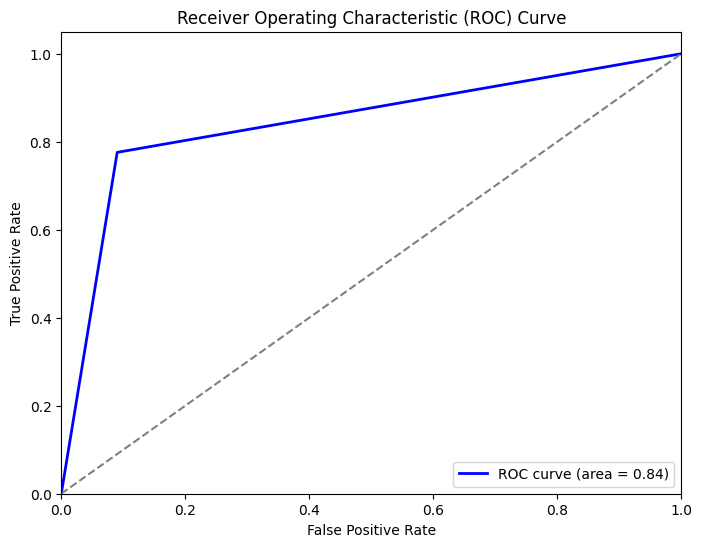

In [300]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

vc_y_pred
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, vc_y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


I meant to raise precision metrics i would raise the threshold to 0.7 or 0.8. In last year in data there was only 8% of nok products. This means quality personnel needs to perform quality check on every shipment even when most of them are ok. In business terms together with growing sales and growing amount of ordered goods this means the need of many QC personel to relatively low defects (8% or lower in future years due to positive impact of quality personel on suppliers, etc).
Having higher precision could help mitigate unnecessary controlls  where model is quite confitdent of OK label.

By adjusting the threshold, you can tailor your decision-making process to balance between the risk of missing defective products and the efficiency of your quality control personnel. Increasing the threshold to 0.95 allows you to confidently identify a subset of products as OK, reducing the need for inspection. Then, lowering the threshold back to 0.5 enables you to focus specifically on the products predicted as NOK for inspection, optimizing the allocation of resources and ensuring thorough quality control. This iterative approach, combined with evaluating different threshold choices using relevant metrics, helps you optimize your operational strategies while maintaining product quality and minimizing unnecessary inspections.

In [321]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Convert probabilities to binary predictions based on a threshold (e.g., 0.5)
y_pred_binary = (vc_y_proba[:,1] >= 0.85).astype(int)

# Compute precision, recall, and F1 score for the negative class
precision = precision_score(y_test, y_pred_binary, pos_label=1)
recall = recall_score(y_test, y_pred_binary, pos_label=1)
f1 = f1_score(y_test, y_pred_binary, pos_label=1)
precision_negative = precision_score(y_test, y_pred_binary, pos_label=0)
recall_negative = recall_score(y_test, y_pred_binary, pos_label=0)
f1_negative = f1_score(y_test, y_pred_binary, pos_label=0)

print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))

print("Precision (Negative Class): {:.2f}".format(precision_negative))
print("Recall (Negative Class): {:.2f}".format(recall_negative))
print("F1 Score (Negative Class): {:.2f}".format(f1_negative))

Precision: 0.96
Recall: 0.58
F1 Score: 0.73
Precision (Negative Class): 0.70
Recall (Negative Class): 0.98
F1 Score (Negative Class): 0.82


In [322]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[888  21]
 [379 531]]


### Lower frequency class prediction(less then 50 deliveries)

In [ ]:
to_modeling_df.shape

In [ ]:
modified_df.shape

In [ ]:
combo_counts = modified_df[['drawing_no', 'surface_finish', 'name']].apply(tuple, axis=1)
vc_combo_counts = combo_counts.value_counts()
sliced_vc_combo_counts = vc_combo_counts[vc_combo_counts<50]
filtered_rows_df = modified_df[combo_counts.isin(sliced_vc_combo_counts[sliced_vc_combo_counts].index)]
filtered_rows_df_idx = filtered_rows_df.index
# len(sliced_vc_combo_counts)
filtered_rows_df_idx

In [ ]:
low_class_to_predict_df = to_modeling_df.loc[filtered_rows_df_idx]
low_class_to_predict_df.shape

In [ ]:
# low_class_to_predict_df = low_class_to_predict_df.drop(['date_fmt', 'OK_NOK', 'date_numeric'], axis=1)

In [ ]:
columns_to_keep_features = [col for col in low_class_to_predict_df.columns if col not in ['date_fmt', 'OK_NOK','date_numeric']]
low_class_to_predict_df_features = low_class_to_predict_df[columns_to_keep_features]

columns_to_keep_target = [col for col in low_class_to_predict_df.columns if col in ['OK_NOK']]
low_class_to_predict_df_labels = low_class_to_predict_df[columns_to_keep_target]



In [ ]:
print(low_class_to_predict_df_features.shape)
low_class_to_predict_df_labels.shape

In [ ]:
features = low_class_to_predict_df_features.copy()
labels = low_class_to_predict_df_labels
y_pred = votingC.predict(features)

In [ ]:
y_pred

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(labels, y_pred)


In [ ]:
y_pred.shape

In [ ]:
features.shape